In [1]:
#Data Wrangling & EDA
import pandas as pd
import numpy as np
import statsmodels.api as sm

#Data rescale
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')


# Creeting a cluster
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from numpy import set_printoptions
from sklearn.decomposition import PCA

# Split the data and work with unbalanced class
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split



# Model Creation

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#Evaluate the models

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve,precision_score, recall_score,accuracy_score,classification_report

# setting Jupyter outputs

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
pd.options.display.float_format= '{:.2f}'.format

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [181]:
#Importamos los 2 data sources y los unimos en un único dataframe utilizando el order id
csv1 = pd.read_csv("../Dataset/datatable 1 v2.csv", sep = ';', decimal=',', low_memory=False)
csv2 = pd.read_csv("../Dataset/datatable 2 v2.csv", sep = ';', decimal=',')
df = pd.merge(csv1, csv2, on="ecomm_order_id", how="inner")


df.head()

,ecomm_order_id,ecommerce,store,ecomm_creation_date_x,numero_lote,fecha_facturado,linea,marca,vArticulo_id,vTalle_Codigo,producto,quantity,client_price,PrecioCosto,ecomm_tipo_envio,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular,ecomm_transporte_nombre,sucursal_original,ultima_sucursal,ColorPrimario,ProveedorId,Disciplina,Genero,sex,description,ecomm_creation_date_y,date_handling,date_invoiced,date_canceled,email,adress_id,latitude,longitude,payment,client_id
0,1100450257447-01,vtex,Dash,2/1/2021 18:04,8851.00,4/1/2021 15:06,INDUMENTARIA,ADIDAS FUTBOL,266-0576,XXL*,CAMISETA ADIDAS RIVER PLATE VISITANTE 20/21 2...,1,5439.20,3649.02,residential,4829.34,8999.00,Envio a domicilio Estándar,NaN,NaN,ROJO ...,FQ7662,FUTBOL,HOMBRE ...,NaN,vtex,2/1/2021 18:04,2/1/2021 18:32,4/1/2021 15:16,\N,f8477045016e49dbb93d73735e31eb09@ct.vtex.com.br,\N,-57.637.779.235.839.800,-379.647.216.796.875,Mercado Pago,efdee559517295b10d370194a81b9f6d
1,1100502308757-01,vtex,Grid,3/1/2021 01:38,8854.00,4/1/2021 15:55,CALZADO ADULTOS,PUMA,961-1271,05 *,ZAPATILLAS PUMA MILE RIDER SUNNY 961-1271-05.0,1,9499.00,5420.50,residential,6052.00,7899.00,Envio a domicilio Estándar,NaN,NaN,BLANCO,373443/05,MODA,MUJER ...,F,vtex,2/1/2021 22:38,2/1/2021 23:02,4/1/2021 16:03,\N,dc1b76171333439faaba9d2bbb46b258@ct.vtex.com.br,\N,-58.263.946.533.203.100,-347.640.495.300.293,Mercado Pago,6631617bf8504256ddb0efc8823ba702
2,1100502308757-01,vtex,Grid,3/1/2021 01:38,8854.00,4/1/2021 15:55,INDUMENTARIA,NIKE,302-0026,M *,REMERA NIKE ICON CLASH 302-0026-M,1,3839.00,2525.79,residential,3315.26,4699.00,Envio a domicilio Estándar,NaN,NaN,BLANCO,CJ2040-100,MODA,MUJER ...,F,vtex,2/1/2021 22:38,2/1/2021 23:02,4/1/2021 16:03,\N,dc1b76171333439faaba9d2bbb46b258@ct.vtex.com.br,\N,-58.263.946.533.203.100,-347.640.495.300.293,Mercado Pago,6631617bf8504256ddb0efc8823ba702
3,1100691010085-01,vtex,Grid,3/1/2021 18:16,8840.00,4/1/2021 07:56,INDUMENTARIA,FILA DASS,432-0105,S *,REMERA FILA BIELLA BOX ITALY 432-0105-S,1,799.00,526.60,pickup,526.60,799.00,Envio-24hs,(G08),NaN,BLANCO,LS180827 101,MODA,MUJER ...,F,vtex,3/1/2021 18:16,3/1/2021 18:41,4/1/2021 08:01,\N,f69943d53e2c4e9daa47e756cc23e84f@ct.vtex.com.br,\N,-5.862.068,-3.464.903,Mercado Pago,20ddb8685617bd8ce6171fa47461e506
4,1100692868583-01,vtex,Dash,3/1/2021 20:47,8854.00,4/1/2021 15:16,CALZADO ADULTOS,ADIDAS ARGENTINAS,261-1688,07.5,ZAPATILLAS ADIDAS X9000L1 261-1688-07.5,1,8999.00,4829.76,residential,5366.00,6999.00,Envio a domicilio Estándar,NaN,NaN,NEGRO,EG4794,RUNNING,MUJER ...,F,vtex,3/1/2021 17:47,3/1/2021 18:11,4/1/2021 15:27,\N,e8b7ec3f47014aa094e3a7449a725b47@ct.vtex.com.br,\N,-6.630.628.204.345.700,1.818.662.452.697.750,Mercado Pago,0b3300233664137120bd84ce40752a1b


# Análisis exploratorio de los datos
# Limpieza y visualización de datos

In [182]:
#Vistazo general de info del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58169 entries, 0 to 58168
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecomm_order_id                58169 non-null  object 
 1   ecommerce                     58169 non-null  object 
 2   store                         58169 non-null  object 
 3   ecomm_creation_date_x         58169 non-null  object 
 4   numero_lote                   58161 non-null  float64
 5   fecha_facturado               56800 non-null  object 
 6   linea                         57913 non-null  object 
 7   marca                         57913 non-null  object 
 8   vArticulo_id                  58162 non-null  object 
 9   vTalle_Codigo                 58168 non-null  object 
 10  producto                      58169 non-null  object 
 11  quantity                      58169 non-null  int64  
 12  client_price                  58158 non-null  float64
 13  P

In [183]:
def nullValues(dataSet):
    ''' Analize null values '''
    x = dataSet.isna().sum()
    if len(x[x>0])>0:
        d = {'NullRecord': x[x>0], 'TotalRecord': dataSet.shape[0]}
        y = pd.DataFrame(d)
        #y["CompleteRecord"] = y["TotalRecord"] - y["NullRecord"]
        y["Empty %"] = round(y['NullRecord']/y['TotalRecord'],2) 
    return y.sort_values("NullRecord",ascending=True)

nullValues(df)

,NullRecord,TotalRecord,Empty %
vTalle_Codigo,1,58169,0.00
vArticulo_id,7,58169,0.00
numero_lote,8,58169,0.00
client_price,11,58169,0.00
ProveedorId,256,58169,0.00
VArticuloTalle_PrecioRegular,256,58169,0.00
VArticuloTalle_Costo,256,58169,0.00
linea,256,58169,0.00
marca,256,58169,0.00
Genero,287,58169,0.00


### Eliminaremos las siguientes columnas ya que no serán de utilidad para el análisis:
- numero_lote: no propociona información útil
- fecha_facturado: contiene la misma información que date_invoiced (con minutos de diferencia), pero menos cantidad de registros
- PrecioCosto: Debería contener la misma información que VArticuloTalle_Costo. Nos quedamos con la segunda porque tiene mayor cantidad de registros
- sucursal_original: contiene muy pocos datos
- ultima_sucursal: contiene muy pocos datos
- description: es la descripción del ecommerce, o sea que contiene la misma información que el campo "ecommerce"
- ecomm_creation_date_y: es la misma fecha que ecomm_creation_date_x, quedó duplicada al unir los 2 data sources
- ecomm_tipo_envio: No proporciona información útil

In [184]:
#Eliminamos las columnas que no vamos a usar
df.drop(['numero_lote', 'fecha_facturado', 'PrecioCosto','sucursal_original','ultima_sucursal','description','ecomm_creation_date_y','ecomm_tipo_envio'], axis = 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58169 entries, 0 to 58168
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecomm_order_id                58169 non-null  object 
 1   ecommerce                     58169 non-null  object 
 2   store                         58169 non-null  object 
 3   ecomm_creation_date_x         58169 non-null  object 
 4   linea                         57913 non-null  object 
 5   marca                         57913 non-null  object 
 6   vArticulo_id                  58162 non-null  object 
 7   vTalle_Codigo                 58168 non-null  object 
 8   producto                      58169 non-null  object 
 9   quantity                      58169 non-null  int64  
 10  client_price                  58158 non-null  float64
 11  VArticuloTalle_Costo          57913 non-null  float64
 12  VArticuloTalle_PrecioRegular  57913 non-null  float64
 13  e

In [185]:
#Vistazo general de medidas descriptivas de variables cuantitativas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,58169.00,1.02,0.67,1.00,1.00,1.00,1.00,150.00
client_price,58158.00,6886.33,4315.88,-1199.80,4399.00,5999.00,7999.00,27999.00
VArticuloTalle_Costo,57913.00,4434.44,2627.69,0.10,2940.64,4024.36,5262.63,18946.84
VArticuloTalle_PrecioRegular,57913.00,7969.13,4995.45,29.00,4899.00,6699.00,9499.00,35999.00


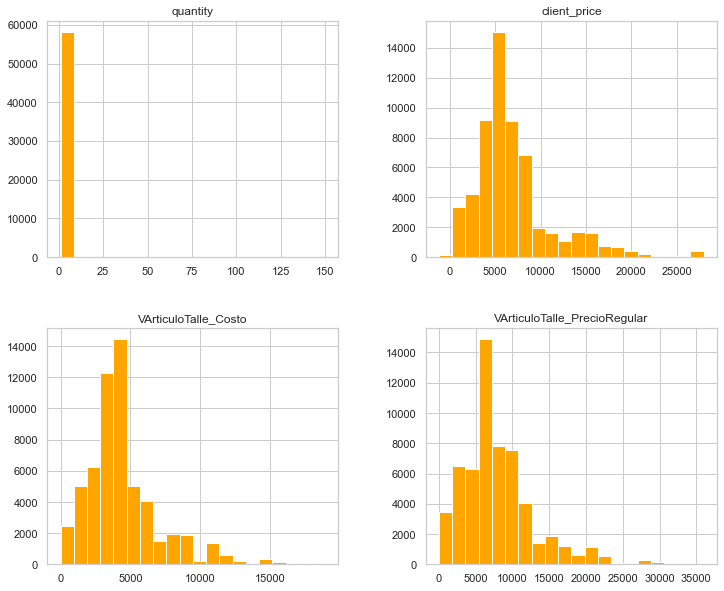

In [186]:
# Histogramas de variables cuantitativas
df.hist(figsize=(12,10), color='orange', bins=20)
plt.show()

Se puede notar que client_price tiene valores negativos, lo cual no tiene sentido y constituye un error de carga en los datos.
Vamos a eliminar esos registros para que no afecten el análisis.

In [187]:
#Eliminamos los registros con precios negativos
df = df.drop(df[df['client_price'] < 0].index)
df[df['client_price'] < 0]

,ecomm_order_id,ecommerce,store,ecomm_creation_date_x,linea,marca,vArticulo_id,vTalle_Codigo,producto,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular,ecomm_transporte_nombre,ColorPrimario,ProveedorId,Disciplina,Genero,sex,date_handling,date_invoiced,date_canceled,email,adress_id,latitude,longitude,payment,client_id


In [188]:
#Análisis particular de la variable "client_price"
variable = 'client_price'

minimo = df[variable].min()
maximo = df[variable].max()
media = df[variable].mean()
mediana = df[variable].median()
moda = df[variable].mode()[0]
stdev = df[variable].std()
varian = df[variable].var()

print('Minimo: ' + str(minimo))
print('Maximo: ' + str(maximo))
print('Media: ' + str(round(media,2)))
print('Mediana: ' + str(mediana))
print('Moda: ' + str(moda))
print('Desviación estándar: ' + str(round(stdev,2)))
print('Varianza: ' + str(round(varian,2)))

Minimo: 0.0
Maximo: 27999.0
Media: 6886.61
Mediana: 5999.0
Moda: 5999.0
Desviación estándar: 4315.69
Varianza: 18625177.46


<Figure size 720x648 with 0 Axes>

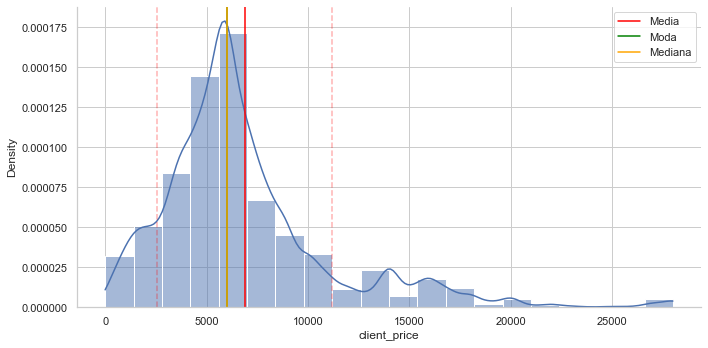

In [189]:
#Histograma y curva de densidad de client_price con media, mediana y moda
plt.figure(figsize=(10, 9))
ax = sns.displot(data=df, 
                 x = variable, 
                 kde=True,
                stat="density",
                height=5,
                aspect=2,
                bins = 20)

plt.axvline(media,
           color = "red",
           label = 'Media')

plt.axvline(media - stdev,
           color = "red",
           alpha = 0.3,
           linestyle = "--")

plt.axvline(media + stdev,
           color = "red",
           alpha = 0.3,
           linestyle = "--")

plt.axvline(moda,
           color = "green",
           alpha = 1,
           label = 'Moda')

plt.axvline(mediana,
           color = "orange",
           alpha = 1,
           label = 'Mediana')

plt.legend()

plt.show()

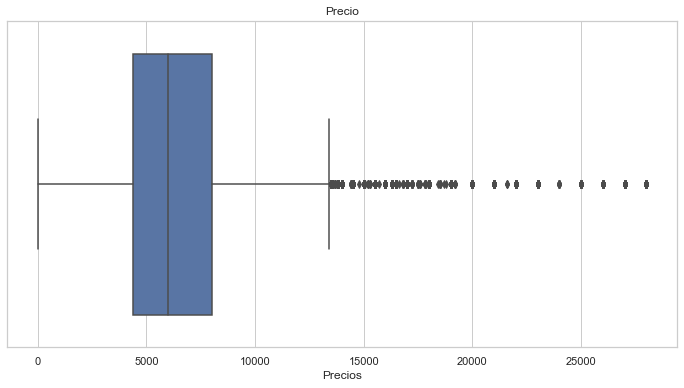

In [190]:
#Boxplot para client_price
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['client_price'])
plt.title('Precio')
plt.xlabel('Precios')
plt.show()

In [191]:
#Análisis particular de la variable "VArticuloTalle_Costo"
variable = 'VArticuloTalle_Costo'

minimo = df[variable].min()
maximo = df[variable].max()
media = df[variable].mean()
mediana = df[variable].median()
moda = df[variable].mode()[0]
stdev = df[variable].std()
varian = df[variable].var()

print('Minimo: ' + str(minimo))
print('Maximo: ' + str(maximo))
print('Media: ' + str(round(media,2)))
print('Mediana: ' + str(mediana))
print('Moda: ' + str(moda))
print('Desviación estándar: ' + str(round(stdev,2)))
print('Varianza: ' + str(round(varian,2)))

Minimo: 0.1
Maximo: 18946.84
Media: 4434.43
Mediana: 4024.3641
Moda: 3452.13
Desviación estándar: 2627.74
Varianza: 6905003.74


<Figure size 720x648 with 0 Axes>

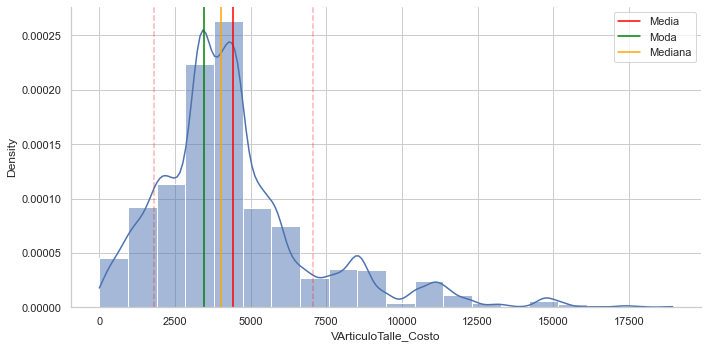

In [192]:
#Histograma y curva de densidad de VArticuloTalle_Costo con media, mediana y moda
plt.figure(figsize=(10, 9))
ax = sns.displot(data=df, 
                 x = variable, 
                 kde=True,
                stat="density",
                height=5,
                aspect=2,
                bins=20)

plt.axvline(media,
           color = "red",
           label = 'Media')

plt.axvline(media - stdev,
           color = "red",
           alpha = 0.3,
           linestyle = "--")

plt.axvline(media + stdev,
           color = "red",
           alpha = 0.3,
           linestyle = "--")

plt.axvline(moda,
           color = "green",
           alpha = 1,
           label = 'Moda')

plt.axvline(mediana,
           color = "orange",
           alpha = 1,
           label = 'Mediana')

plt.legend()

plt.show()

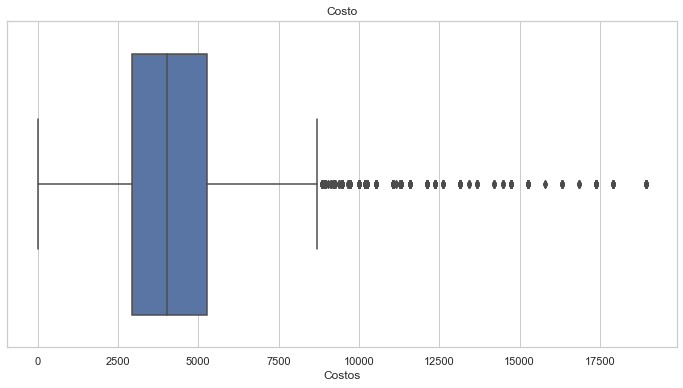

In [193]:
#Boxplot para VArticuloTalle_Costo
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['VArticuloTalle_Costo'])
plt.title('Costo')
plt.xlabel('Costos')
plt.show()

In [194]:
#Análisis de valores únicos de variables categóricas
cat_columns=['ecommerce', 'store', 'linea', 'marca','vTalle_Codigo','ecomm_transporte_nombre','ColorPrimario','Disciplina','Genero','payment','sex']

for i in cat_columns:
    print(df[i].name)
    print(df[i].unique())
    print()

ecommerce
['vtex' 'meli']

store
['Dash' 'Grid' 'Mark' 'Fila' 'Adidas Performance' 'Nike' 'Puma'
 'Rebook Argentina' 'Stadium' 'Adidas Original' 'Umbro']

linea
['INDUMENTARIA        ' 'CALZADO ADULTOS     ' 'ACCESORIOS-REPUESTOS'
 'MEDIAS              ' 'CALZADO NIÑOS       ' 'BOLSOS              ' nan]

marca
['ADIDAS FUTBOL       ' 'PUMA                ' 'NIKE                '
 'FILA DASS           ' 'ADIDAS ARGENTINAS   ' 'TOPPER              '
 'FOOTY MEILY         ' 'NEW BALANCE         ' 'JOHN FOOS ARGENTINA '
 'NIKE ANNEX          ' 'FALLEN              ' 'ATLETIC SERV SA     '
 'O´NEILL             ' 'REEBOK ARGENTINA    ' 'KLALUTEX            '
 'REVES               ' 'BESS II             ' 'CULTURA             '
 'SHOTER              ' 'UNDER ARMOUR        ' 'ZUMM                '
 'GOORIN              ' 'UMBRO DASS          ' 'SPORT COMPLEMENTS   '
 'JAGUAR              ' 'NUEVO EMPORIO       ' 'ASICS ARGENTINA     '
 'JANSPORT            ' 'NIKEGOLF            ' nan 'KONNA

In [195]:
#Normalización de datos de variables categóricas

#linea: quitamos los espacios y reemplazamos los NaN por "DESCONOCIDO"
df['linea'] = df['linea'].str.strip()
df['linea'] = df['linea'].fillna('DESCONOCIDA')

#marca: quitamos los espacios y reemplazamos los NaN por "DESCONOCIDA"
df['marca'] = df['marca'].str.strip()
df['marca'] = df['marca'].fillna('DESCONOCIDA')

#ecomm_transporte_nombre: quitamos espacios y unificamos los que significan lo mismo
df['ecomm_transporte_nombre'] = df['ecomm_transporte_nombre'].str.strip()
df['ecomm_transporte_nombre'] = df['ecomm_transporte_nombre'].replace(to_replace =["Estándar a domicilio", "Normal a domicilio"], value ="Envio a domicilio Estándar")
df['ecomm_transporte_nombre'] = df['ecomm_transporte_nombre'].replace(to_replace =["Transporte interno Essential Meli"], value ="Transporte interno Essential")
df['ecomm_transporte_nombre'] = df['ecomm_transporte_nombre'].replace(to_replace =["Express a domicilio", "Envio-24hs"], value ="Prioritario a domicilio")

#ColorPrimario: quitamos los espacios y reemplazamos los NaN por "DESCONOCIDO"
df['ColorPrimario'] = df['ColorPrimario'].str.strip()
df['ColorPrimario'] = df['ColorPrimario'].fillna('DESCONOCIDO')

#Disciplina: quitamos espacios, reemplazamos NaN por "DESCONOCIDA" y unificamos los que significan lo mismo
df['Disciplina'] = df['Disciplina'].str.strip()
df['Disciplina'] = df['Disciplina'].fillna('DESCONOCIDA')
df['Disciplina'] = df['Disciplina'].replace(to_replace =["TENNIS"], value ="TENIS")

#Genero: quitamos los espacios y reemplazamos los NaN por "DESCONOCIDO"
df['Genero'] = df['Genero'].str.strip()
df['Genero'] = df['Genero'].fillna('DESCONOCIDO')

#payment: unificamos los que significan lo mismo y reemplazamos '\\N' por "Desconocido"
df = df.replace({"creditCard": "credit_card","account_money": "MercadoPago", "\\N":"Desconocido"})

#sex: reemplazamos NaN por "Desconocido"
df['sex'] = df['sex'].fillna('DESCONOCIDO')


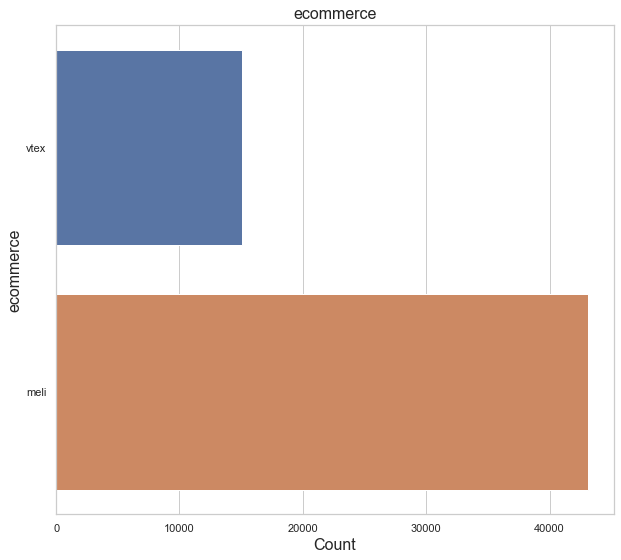

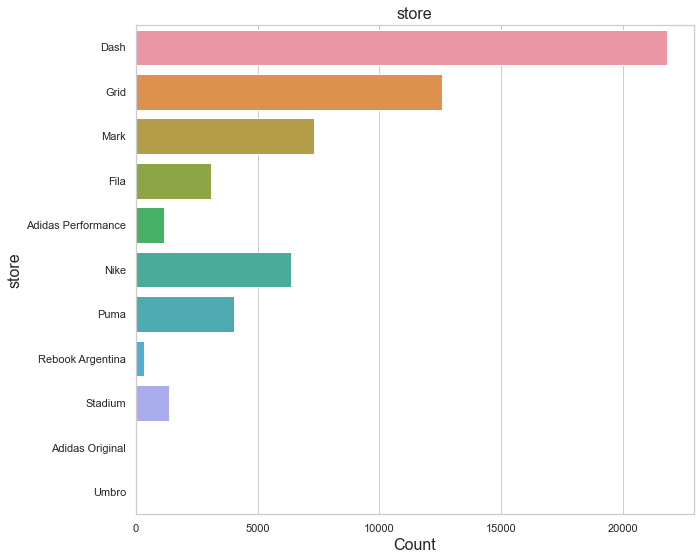

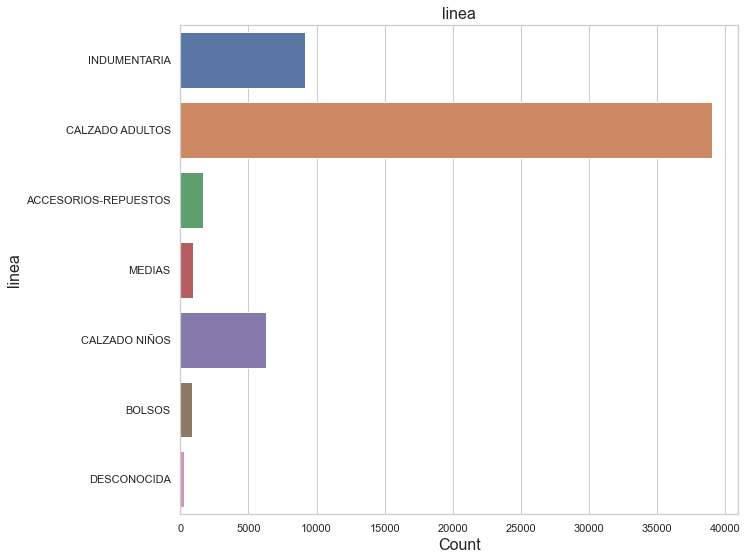

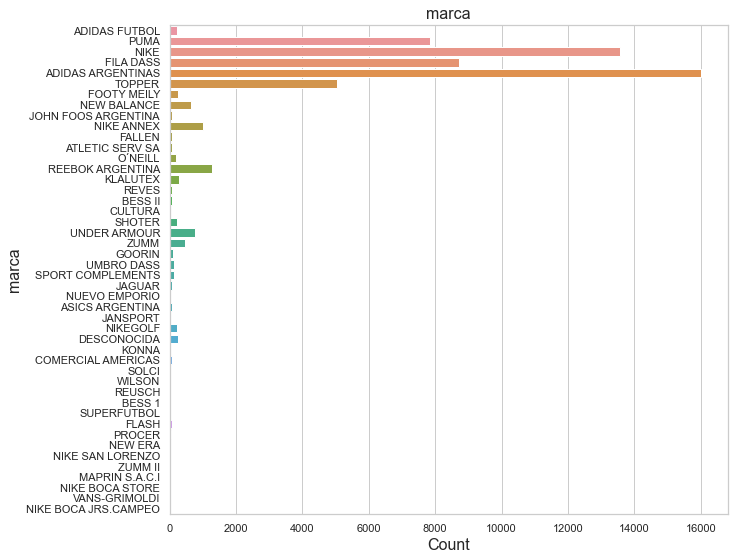

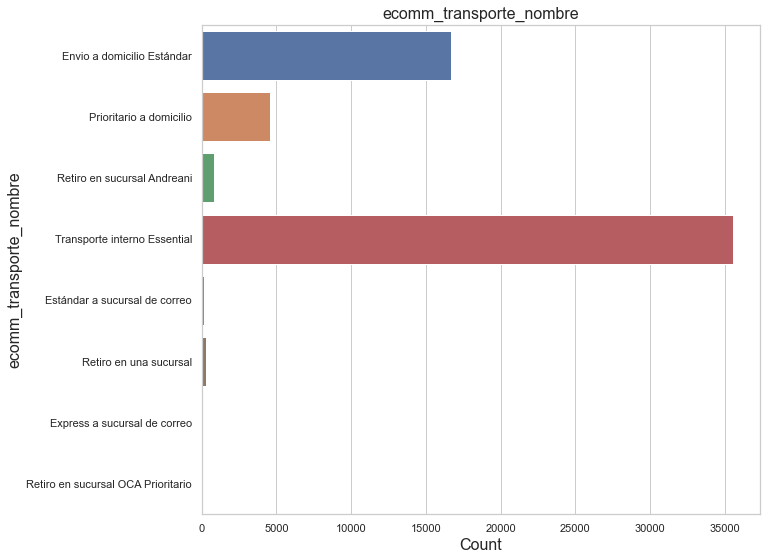

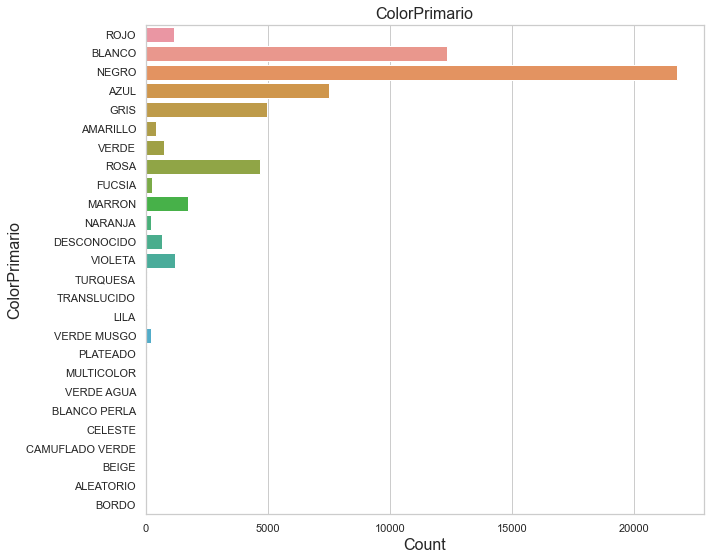

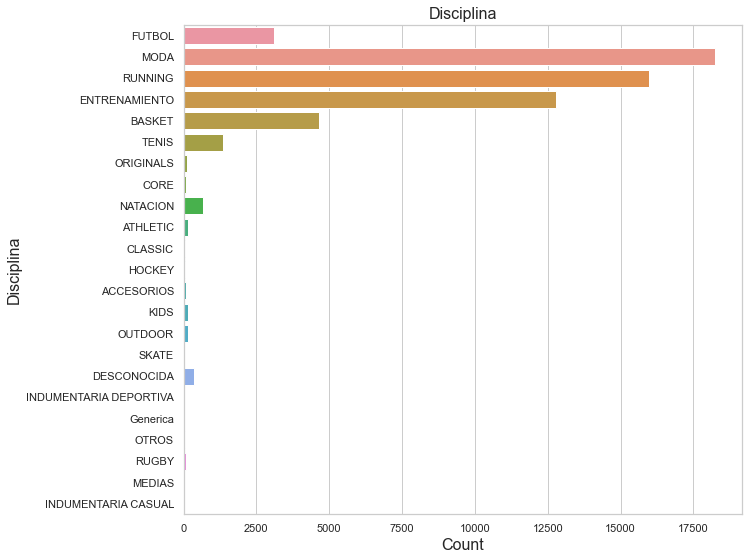

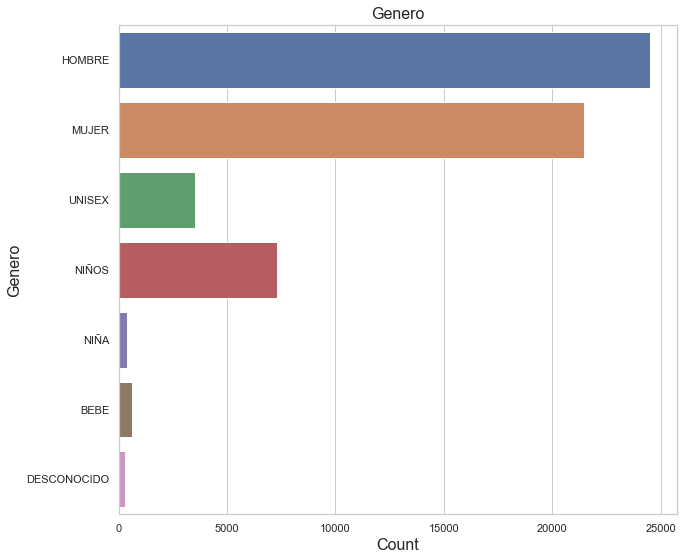

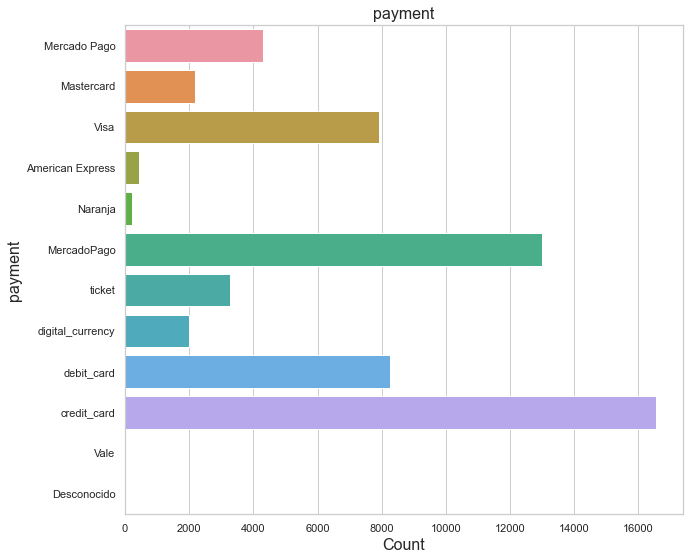

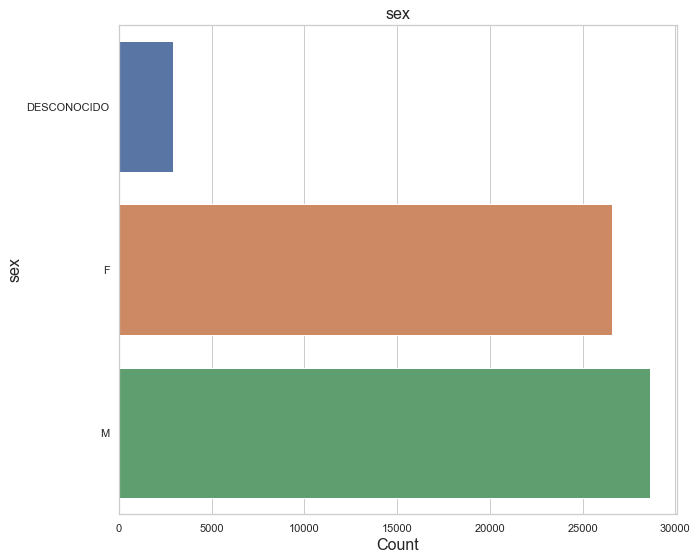

In [196]:
#Análisis de frecuencias de variables categóricas (excepto talle)
cat_columns=['ecommerce', 'store', 'linea', 'marca','ecomm_transporte_nombre','ColorPrimario','Disciplina','Genero','payment','sex']

for i in cat_columns:
    df[i] = df[i].str.rstrip()

for i in cat_columns:
    plt.figure(figsize=(10,9))
    plt.title(i,fontsize=16)
    plt.rcParams['figure.facecolor'] = 'White'
    sns.countplot(y=df[i])
    plt.xlabel('Count',fontsize=16)
    plt.ylabel(i,fontsize=16)
    plt.show()

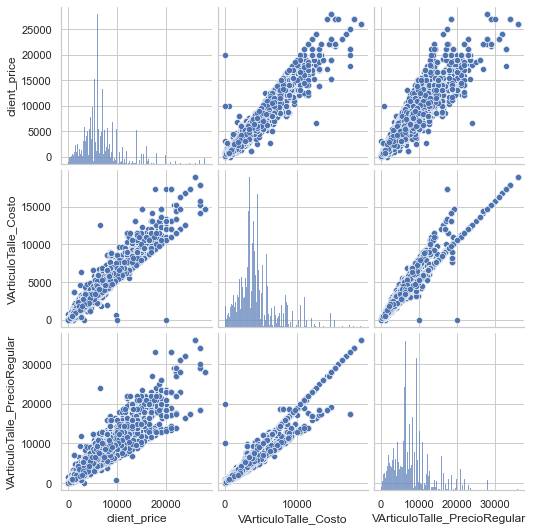

In [197]:
#Scatterplots para ver las relaciones entre todas las variables cuantitativas
sns.pairplot(df[['client_price','VArticuloTalle_Costo','VArticuloTalle_PrecioRegular']])
plt.show()

In [198]:
#Cálculo de la correlación entre variables
df.corr()

,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular
quantity,1.00,-0.03,-0.03,-0.03
client_price,-0.03,1.00,0.96,0.93
VArticuloTalle_Costo,-0.03,0.96,1.00,0.96
VArticuloTalle_PrecioRegular,-0.03,0.93,0.96,1.00


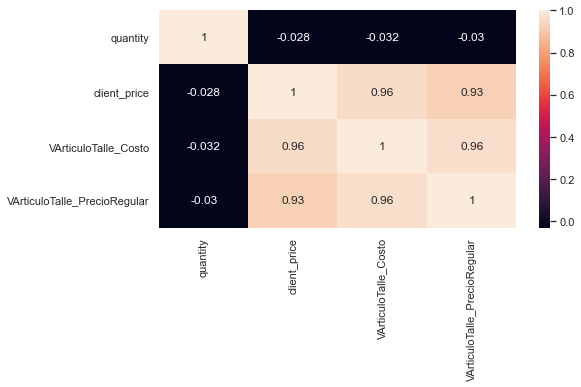

In [199]:
#Heatmap de la correlación
plt.subplots(figsize=(8, 4))
sns.heatmap(df.corr(),annot=True)
plt.show()

En base a los gráficos anteriores se puede notar que todas las variables de precio y costo están altamente correlacionadas positivamente (si una crece la otra también), lo cual tiene sentido ya que la ganancia se genera vendiendo a un precio superior al costo

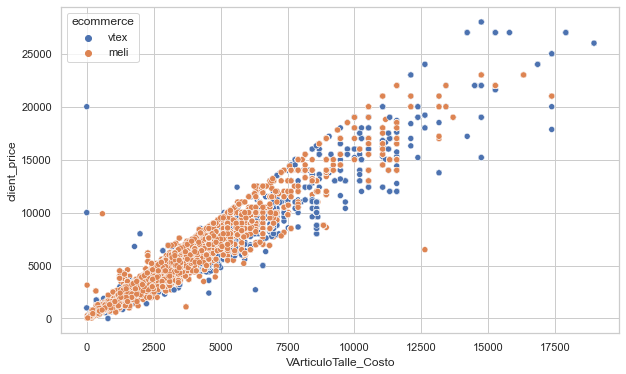

In [200]:
#Analizamos particularmente la relación entre el costo y el precio por ecommerce
plt.subplots(figsize=(10, 6))
sns.scatterplot(x='VArticuloTalle_Costo', y='client_price', hue='ecommerce', data=df)
plt.show()

### Se puede notar que:

Para costos similares Meli en general vende a un mayor precio, por lo que es probable que genere mayor ganancia.
Hay algunos casos atípicos a analizar donde el costo es 0 y el artículo se vendió con un precio determinado.
Meli tiene mayor concentración de puntos en precios menores a 10000, por lo que es probable que genere mayor cantidad de ventas de productos en ese rango de precios.

In [201]:
#Agregamos la variable "ganancia" (precio - costo) para analizar algunas cuestiones en base a la misma
df["ganancia"] = df["client_price"] - df["VArticuloTalle_Costo"]
df[['client_price','VArticuloTalle_Costo','ganancia']]

,client_price,VArticuloTalle_Costo,ganancia
0,5439.20,4829.34,609.86
1,9499.00,6052.00,3447.00
2,3839.00,3315.26,523.74
3,799.00,526.60,272.40
4,8999.00,5366.00,3633.00
...,...,...,...
58164,5490.00,3452.13,2037.87
58165,2999.00,2833.69,165.31
58166,8999.00,4736.32,4262.68
58167,6319.00,4037.23,2281.77


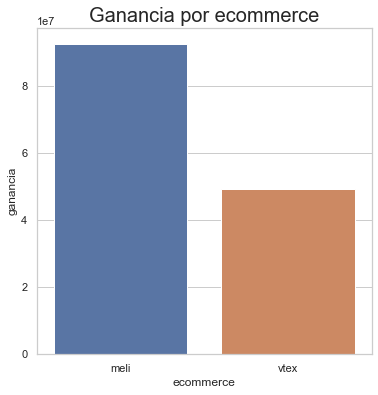

In [202]:
#Vemos cantidad de ventas y ganancia por ecommerce
cat = df[["ecommerce", "ganancia"]].groupby(['ecommerce'], as_index=False).sum().sort_values(by='ganancia', ascending=False)
plt.figure(figsize=(6,6))
sns.set_theme(style="whitegrid")
sns.barplot(x='ecommerce', y='ganancia', data=cat)
plt.title('Ganancia por ecommerce',fontsize=20)
plt.show()

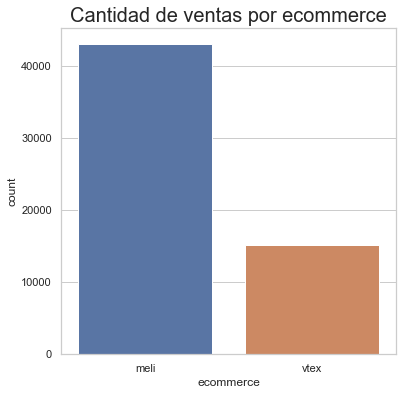

In [203]:
plt.figure(figsize=(6,6))
sns.set_theme(style="whitegrid")
sns.countplot(x = 'ecommerce',
              data = df,
              order = df['ecommerce'].value_counts().index)
plt.title('Cantidad de ventas por ecommerce',fontsize=20)
plt.show()

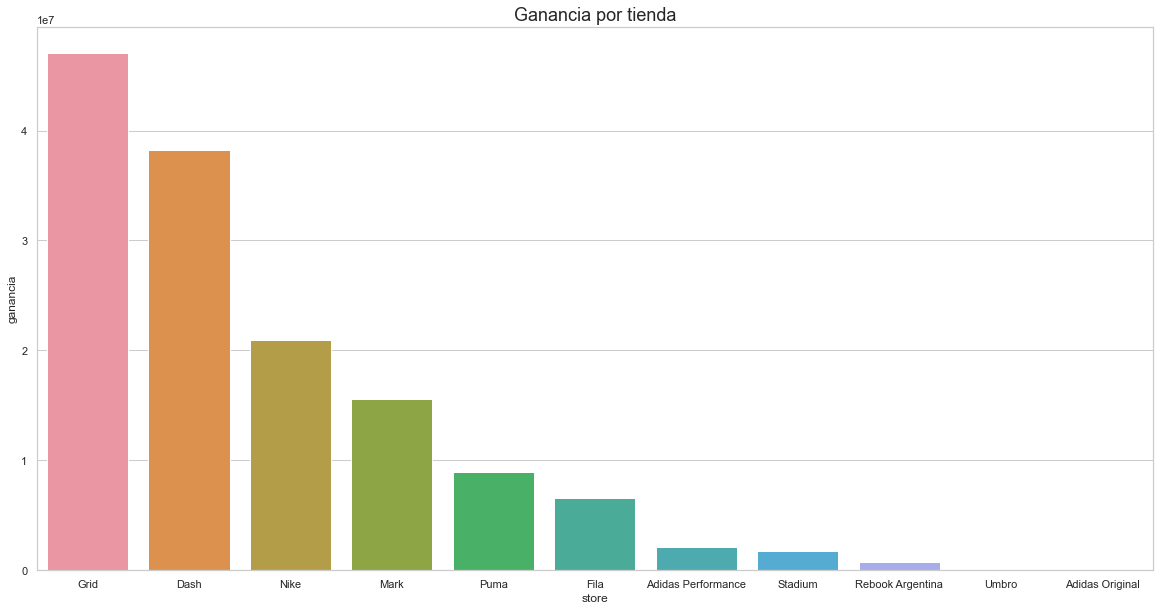

In [204]:
#Analizamos las ganancias por tienda
cat = df[["store", "ganancia"]].groupby(['store'], as_index=False).sum().sort_values(by='ganancia', ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x='store', y='ganancia', data=cat)
plt.title('Ganancia por tienda',fontsize=18)
plt.show()

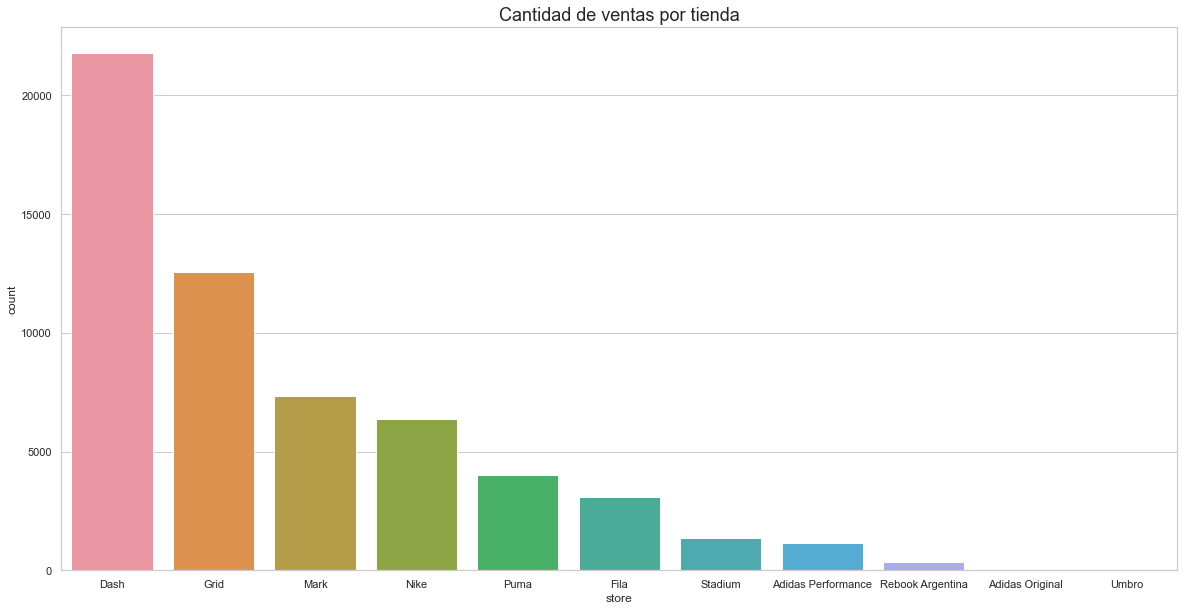

In [205]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.countplot(x = 'store',
              data = df,
              order = df['store'].value_counts().index)
plt.title('Cantidad de ventas por tienda',fontsize=18)
plt.show()

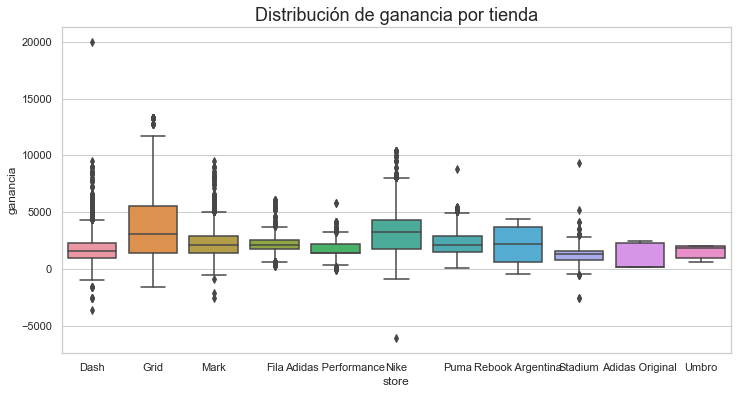

In [206]:
# Boxplot que muestra la ganancia por tienda

plt.subplots(figsize=(12, 6))
sns.boxplot(x=df['store'], y=df['ganancia'])
plt.title('Distribución de ganancia por tienda',fontsize=18)
plt.show()

In [207]:
df[df['ganancia'] < -5000]

,ecomm_order_id,ecommerce,store,ecomm_creation_date_x,linea,marca,vArticulo_id,vTalle_Codigo,producto,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular,ecomm_transporte_nombre,ColorPrimario,ProveedorId,Disciplina,Genero,sex,date_handling,date_invoiced,date_canceled,email,adress_id,latitude,longitude,payment,client_id,ganancia
43180,4333678921,meli,Nike,29/1/2021 02:14,CALZADO ADULTOS,NIKE,306-5639,09 *,Botines Nike Tiempo Legend 8 Pro Fg Hombre,1,6499.00,12631.05,23999.00,Transporte interno Essential,NEGRO,AT6133-004,FUTBOL,HOMBRE,M,Desconocido,29/1/2021 09:25,Desconocido,ttincho.61zfk1r+2-ogqztgmzwg44dsnrx@mail.merca...,Desconocido,Desconocido,Desconocido,digital_currency,81e7601002a411dc674f1219170eaf33,-6132.05


### Se puede notar que:

La tienda "Grid" es la que mayor ganancia genera.
La segunda que mayor ganancia genera es "Dash", pero de acuerdo al boxplot tiene en promedio ganancias menores a varias de las tiendas y algunos outliers a analizar. También es la que mayor cantidad de ventas tiene.Ambas tienen pérdidas probablemente por las promociones que ofrecen.
"Nike" tiene un caso de pérdida mayor a 5000 que habría que analizar en detalle para ver si corresponde a un error de datos o hubo realmente una venta con esa pérdida.

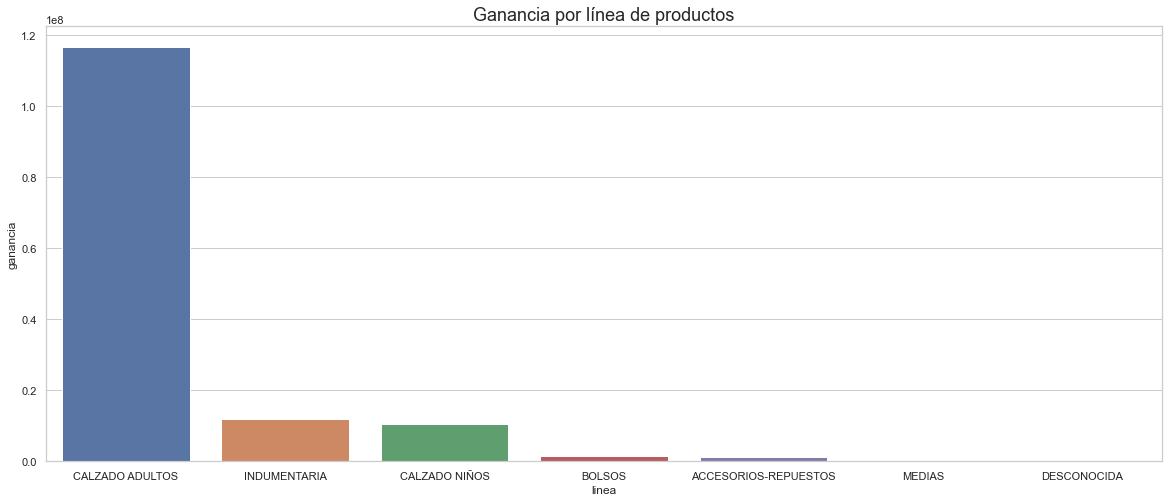

In [208]:
#Analizamos las ganancias por línea de producto
cat = df[["linea", "ganancia"]].groupby(['linea'], as_index=False).sum().sort_values(by='ganancia', ascending=False)
plt.figure(figsize=(20,8))
sns.barplot(x='linea', y='ganancia', data=cat)
plt.title('Ganancia por línea de productos',fontsize=18)
plt.show()

In [209]:
#Análisis de ventas género vs tienda
pd.crosstab(df.Genero, df.store, normalize='columns')

store,Adidas Original,Adidas Performance,Dash,Fila,Grid,Mark,Nike,Puma,Rebook Argentina,Stadium,Umbro
Genero,,,,,,,,,,,
BEBE,0.00,0.01,0.01,0.00,0.01,0.01,0.01,0.02,0.00,0.00,0.00
DESCONOCIDO,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02
HOMBRE,0.49,0.22,0.36,0.44,0.49,0.52,0.38,0.50,0.53,0.29,0.67
MUJER,0.51,0.63,0.38,0.50,0.29,0.32,0.37,0.43,0.44,0.41,0.00
NIÑA,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00
NIÑOS,0.00,0.07,0.15,0.06,0.13,0.08,0.16,0.04,0.02,0.20,0.27
UNISEX,0.00,0.06,0.07,0.01,0.07,0.06,0.05,0.01,0.01,0.07,0.04


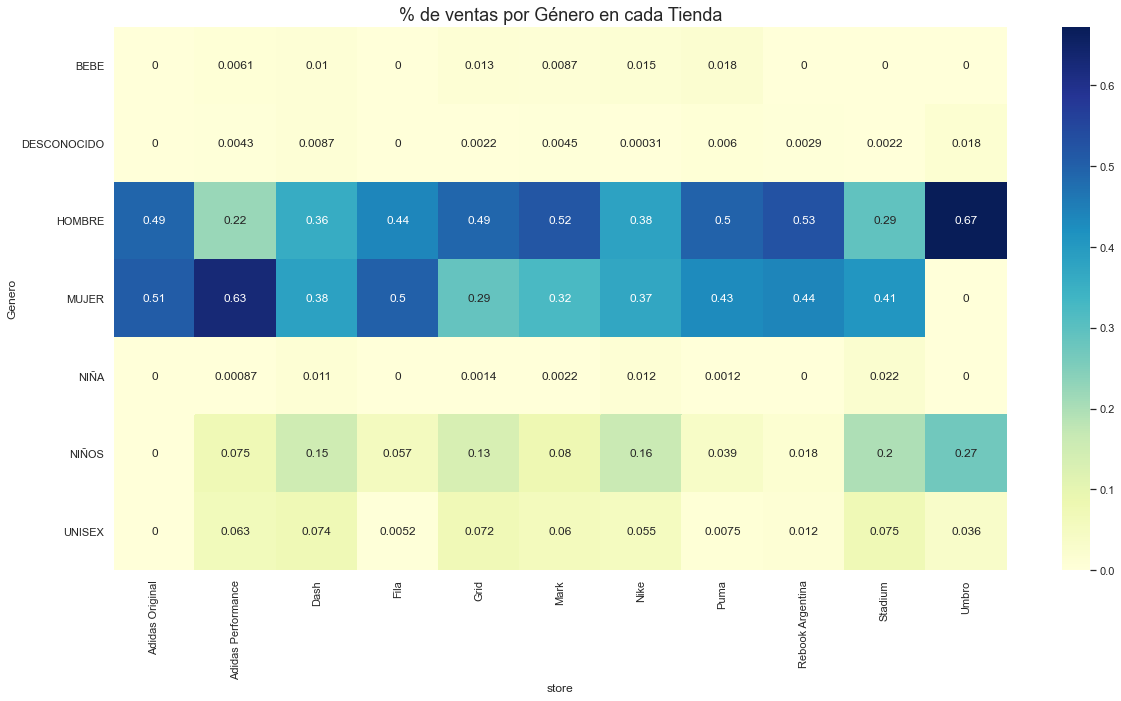

In [210]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df.Genero, df.store, normalize='columns'),
            cmap="YlGnBu", annot=True)
plt.title('% de ventas por Género en cada Tienda',fontsize=18)
plt.show()

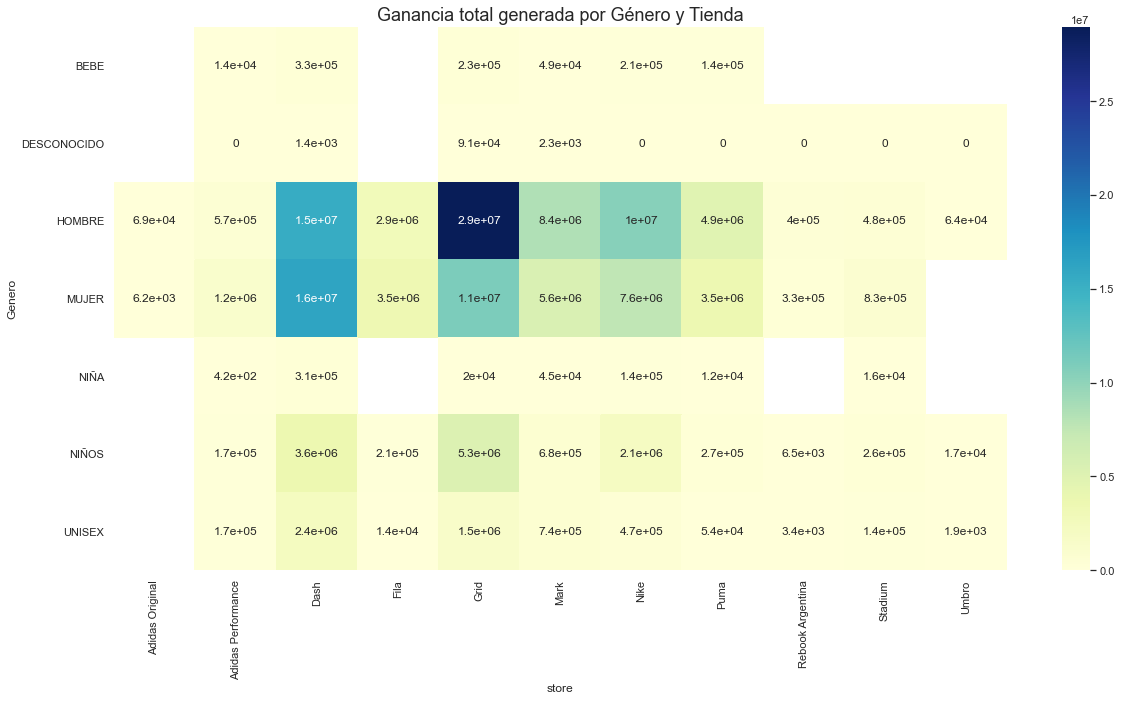

In [211]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df.Genero, df.store, values=df.ganancia, aggfunc='sum').round(0),cmap="YlGnBu", annot=True)
plt.title('Ganancia total generada por Género y Tienda',fontsize=18)
plt.show()

### Se puede notar que:

Casi todas las tiendas venden mayoritariamente productos para hombre y mujer, a excepción de "Umbro" que tiene un 50% de ventas en productos para niños.
La mayor ganancia la genera la tienda "Grid" con artículos para hombres, seguida de "Dash" con artículos para hombres y mujeres.

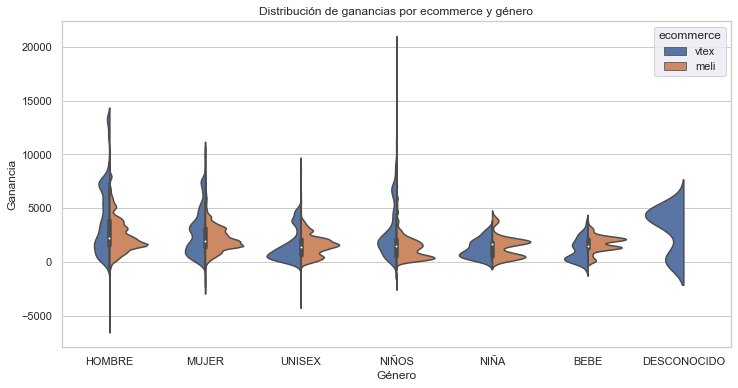

In [212]:
#Distribución de ganancias por ecommerce y género
fig, ax = plt.subplots(figsize=(12, 6))
sns.set()
ax = sns.violinplot(x='Genero', y='ganancia', hue='ecommerce',data=df, split=True)
ax.set(ylabel='Ganancia', xlabel='Género', title='Distribución de ganancias por ecommerce y género')
plt.show()

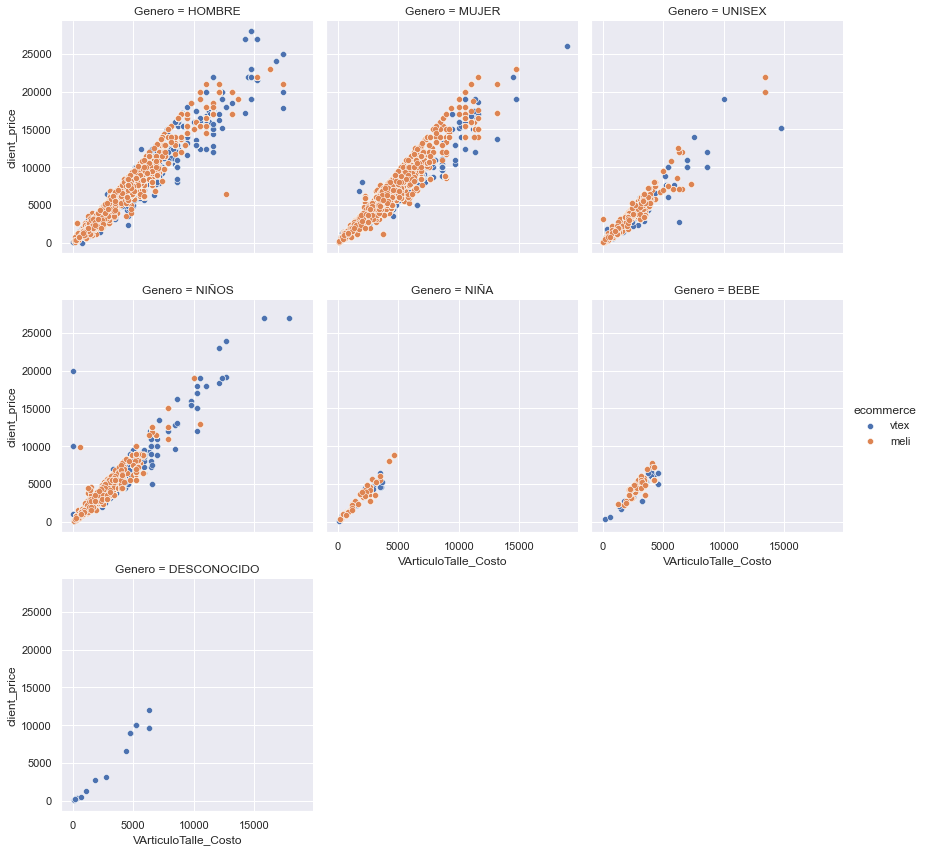

In [213]:
#Scatterplot precio y costo dividido por cada género y por ecommerce 
g = sns.FacetGrid(df, col="Genero",  hue="ecommerce", height=4, col_wrap=3)
g.map(sns.scatterplot, "VArticuloTalle_Costo", "client_price")
g.add_legend()
plt.show()

In [214]:
#Análisis de cantidad vendida y ganancia por disciplina
df_disciplina = pd.DataFrame(df.groupby('Disciplina').sum())[['quantity', 'ganancia']]
df_disciplina

,quantity,ganancia
Disciplina,,
ACCESORIOS,98,54096.30
ATHLETIC,166,90099.43
BASKET,4679,29252739.72
CLASSIC,63,29172.95
CORE,83,233702.46
DESCONOCIDA,350,146175.36
ENTRENAMIENTO,12982,23289321.02
FUTBOL,3241,5514998.81
Generica,20,8020.80


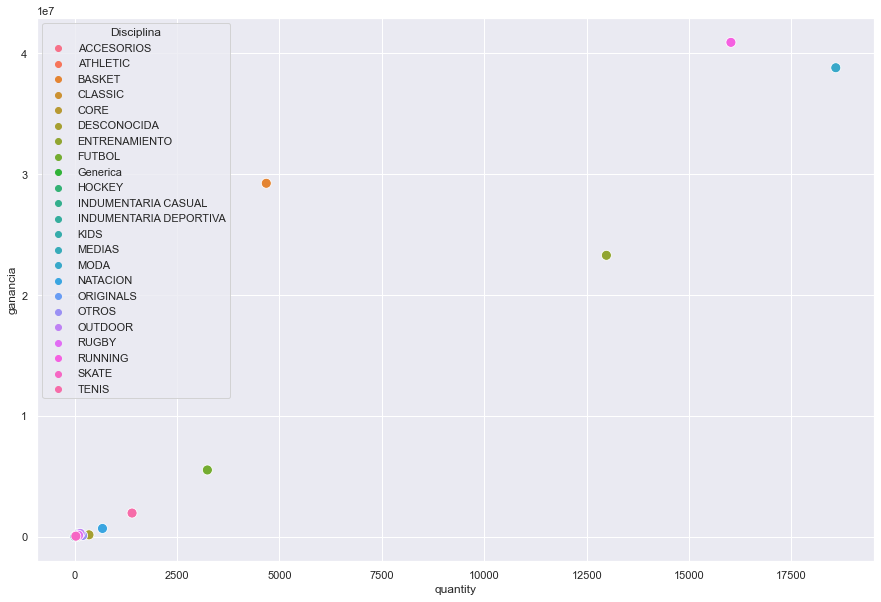

In [215]:
plt.subplots(figsize=(15, 10))
sns.scatterplot(x='quantity', y='ganancia', hue=df_disciplina.index, data=df_disciplina, s=100)
plt.show()

In [216]:
#Análisis de componentes principales para cada disciplina usando las variables cuantitativas
df_store = pd.DataFrame(df.groupby('Disciplina').sum())[['quantity','client_price','VArticuloTalle_Costo','VArticuloTalle_PrecioRegular']]
df_store

,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular
Disciplina,,,,
ACCESORIOS,98,136418.90,82322.60,163362.00
ATHLETIC,166,294114.90,204015.47,325407.00
BASKET,4679,72287448.77,43034709.05,80008706.90
CLASSIC,63,97781.60,68608.65,118476.00
CORE,83,594408.35,360705.89,532217.00
DESCONOCIDA,350,1998654.20,160797.64,266433.00
ENTRENAMIENTO,12982,64830283.45,41540962.43,75472777.40
FUTBOL,3241,14956005.83,9442217.02,16239669.90
Generica,20,34684.00,26663.20,49899.00


In [217]:
df.head()

,ecomm_order_id,ecommerce,store,ecomm_creation_date_x,linea,marca,vArticulo_id,vTalle_Codigo,producto,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular,ecomm_transporte_nombre,ColorPrimario,ProveedorId,Disciplina,Genero,sex,date_handling,date_invoiced,date_canceled,email,adress_id,latitude,longitude,payment,client_id,ganancia
0,1100450257447-01,vtex,Dash,2/1/2021 18:04,INDUMENTARIA,ADIDAS FUTBOL,266-0576,XXL*,CAMISETA ADIDAS RIVER PLATE VISITANTE 20/21 2...,1,5439.20,4829.34,8999.00,Envio a domicilio Estándar,ROJO,FQ7662,FUTBOL,HOMBRE,DESCONOCIDO,2/1/2021 18:32,4/1/2021 15:16,Desconocido,f8477045016e49dbb93d73735e31eb09@ct.vtex.com.br,Desconocido,-57.637.779.235.839.800,-379.647.216.796.875,Mercado Pago,efdee559517295b10d370194a81b9f6d,609.86
1,1100502308757-01,vtex,Grid,3/1/2021 01:38,CALZADO ADULTOS,PUMA,961-1271,05 *,ZAPATILLAS PUMA MILE RIDER SUNNY 961-1271-05.0,1,9499.00,6052.00,7899.00,Envio a domicilio Estándar,BLANCO,373443/05,MODA,MUJER,F,2/1/2021 23:02,4/1/2021 16:03,Desconocido,dc1b76171333439faaba9d2bbb46b258@ct.vtex.com.br,Desconocido,-58.263.946.533.203.100,-347.640.495.300.293,Mercado Pago,6631617bf8504256ddb0efc8823ba702,3447.00
2,1100502308757-01,vtex,Grid,3/1/2021 01:38,INDUMENTARIA,NIKE,302-0026,M *,REMERA NIKE ICON CLASH 302-0026-M,1,3839.00,3315.26,4699.00,Envio a domicilio Estándar,BLANCO,CJ2040-100,MODA,MUJER,F,2/1/2021 23:02,4/1/2021 16:03,Desconocido,dc1b76171333439faaba9d2bbb46b258@ct.vtex.com.br,Desconocido,-58.263.946.533.203.100,-347.640.495.300.293,Mercado Pago,6631617bf8504256ddb0efc8823ba702,523.74
3,1100691010085-01,vtex,Grid,3/1/2021 18:16,INDUMENTARIA,FILA DASS,432-0105,S *,REMERA FILA BIELLA BOX ITALY 432-0105-S,1,799.00,526.60,799.00,Prioritario a domicilio,BLANCO,LS180827 101,MODA,MUJER,F,3/1/2021 18:41,4/1/2021 08:01,Desconocido,f69943d53e2c4e9daa47e756cc23e84f@ct.vtex.com.br,Desconocido,-5.862.068,-3.464.903,Mercado Pago,20ddb8685617bd8ce6171fa47461e506,272.40
4,1100692868583-01,vtex,Dash,3/1/2021 20:47,CALZADO ADULTOS,ADIDAS ARGENTINAS,261-1688,07.5,ZAPATILLAS ADIDAS X9000L1 261-1688-07.5,1,8999.00,5366.00,6999.00,Envio a domicilio Estándar,NEGRO,EG4794,RUNNING,MUJER,F,3/1/2021 18:11,4/1/2021 15:27,Desconocido,e8b7ec3f47014aa094e3a7449a725b47@ct.vtex.com.br,Desconocido,-6.630.628.204.345.700,1.818.662.452.697.750,Mercado Pago,0b3300233664137120bd84ce40752a1b,3633.00


In [218]:
for c in cat_columns:
    print(c)
    print(df[c].value_counts())
    print('\n')


ecommerce
meli    43073
vtex    15094
Name: ecommerce, dtype: int64


store
Dash                  21805
Grid                  12579
Mark                   7335
Nike                   6365
Puma                   4015
Fila                   3091
Stadium                1369
Adidas Performance     1152
Rebook Argentina        340
Adidas Original          61
Umbro                    55
Name: store, dtype: int64


linea
CALZADO ADULTOS         39012
INDUMENTARIA             9118
CALZADO NIÑOS            6321
ACCESORIOS-REPUESTOS     1655
MEDIAS                    921
BOLSOS                    884
DESCONOCIDA               256
Name: linea, dtype: int64


marca
ADIDAS ARGENTINAS       16008
NIKE                    13573
FILA DASS                8730
PUMA                     7843
TOPPER                   5048
REEBOK ARGENTINA         1277
NIKE ANNEX                996
UNDER ARMOUR              758
NEW BALANCE               650
ZUMM                      475
KLALUTEX                  275
FOOTY ME

### Para realizar los siguientes análisis utilizaremos las siguientes varuiales:
    - 'Store'
    - 'Línea'
    - 'Ecomm_Transporte_nombre'
    - 'Disciplina'
    - 'Payment'
    - 'Género'
    - 'Client_price'

In [219]:
print(df['client_price'].isnull().sum())
print(df['ganancia'].isnull().sum())

11
260


#### Vemos que existen variables que tiene valores nulos. Por lo que reemplazaremos esos valores por la mediana para no alterar la distribución.

In [220]:
med=df['client_price'].median()
med1=round(df['ganancia'].median(),2)
df['client_price'].fillna(med,inplace=True)
df['ganancia'].fillna(med1,inplace=True)

In [221]:
# Transformamos las variables categóricas en variables dummies

one_hot_enc=['store','linea','ecomm_transporte_nombre','Disciplina','Genero','payment']

df0=df[one_hot_enc]

df1=pd.get_dummies(df0, drop_first=True)

In [255]:
# Juntamos en DataFrame crado anteriormente con la variable de precio
df_segmentation=pd.concat([df[['client_price','ganancia']],df1],axis=1)
df_model=pd.concat([df[['client_price','ganancia','ecommerce']],df0],axis=1)
df_segmentation.head()

,client_price,ganancia,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket
0,5439.20,609.86,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,9499.00,3447.00,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3839.00,523.74,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,799.00,272.40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,8999.00,3633.00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [256]:
df_model.head()

,client_price,ganancia,ecommerce,store,linea,ecomm_transporte_nombre,Disciplina,Genero,payment
0,5439.20,609.86,vtex,Dash,INDUMENTARIA,Envio a domicilio Estándar,FUTBOL,HOMBRE,Mercado Pago
1,9499.00,3447.00,vtex,Grid,CALZADO ADULTOS,Envio a domicilio Estándar,MODA,MUJER,Mercado Pago
2,3839.00,523.74,vtex,Grid,INDUMENTARIA,Envio a domicilio Estándar,MODA,MUJER,Mercado Pago
3,799.00,272.40,vtex,Grid,INDUMENTARIA,Prioritario a domicilio,MODA,MUJER,Mercado Pago
4,8999.00,3633.00,vtex,Dash,CALZADO ADULTOS,Envio a domicilio Estándar,RUNNING,MUJER,Mercado Pago


In [257]:
# Standarización de datos
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

## Clusterización: Modelo K-menns

In [258]:
# Perform K-means clustering. Armmamos un loop de 10 iteraciones:

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

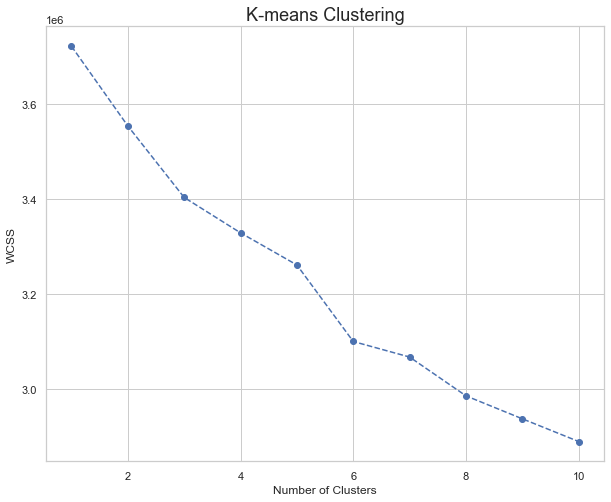

In [259]:
# Ploteamos el resultado para conocer cuantos clusters serán mejor analizar
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering',fontsize=18)
plt.show()

In [260]:
# Corremos K-means con un número fijo de clusters, en este caso:4
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

# Dividimos la data en 3 secciones.
kmeans.fit(segmentation_std)

KMeans(n_clusters=3, random_state=42)

In [261]:
# Creamos un nuevo DataFrame donde se segmente la datta por cada DataFrame
df_segm_kmeans = df_segmentation.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

# Calculamos los valores medios para cada cluster
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means'])[df_segmentation.columns].mean()
df_segm_analysis

,client_price,ganancia,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket
Segment K-means,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8286.72,2991.20,0.02,0.36,0.07,0.20,0.14,0.10,0.08,0.01,0.02,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.01,0.00,0.01,0.64,0.00,0.10,0.00,0.00,0.00,0.24,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.01,0.00,0.00,0.00,0.00,0.36,0.00,0.03,0.00,0.50,0.46,0.00,0.01,0.03,0.00,0.03,0.06,0.20,0.00,0.00,0.12,0.32,0.15,0.04,0.07
1,4003.70,1342.82,0.01,0.40,0.02,0.25,0.10,0.14,0.04,0.01,0.03,0.00,0.05,0.00,0.33,0.00,0.48,0.05,0.00,0.00,0.11,0.02,0.00,0.00,0.55,0.01,0.04,0.00,0.00,0.00,0.19,0.10,0.00,0.00,0.00,0.00,0.01,0.00,0.51,0.01,0.00,0.00,0.00,0.00,0.10,0.00,0.01,0.00,0.27,0.18,0.02,0.37,0.12,0.00,0.04,0.10,0.28,0.01,0.00,0.17,0.20,0.12,0.03,0.03
2,6647.28,1937.79,0.02,0.71,0.00,0.03,0.12,0.01,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.02,0.00,0.24,0.00,0.00,0.02,0.20,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.20,0.00,0.00,0.00,0.43,0.23,0.03,0.09


In [262]:
df_segm_analysis=df_segm_analysis[['client_price','ganancia','store_Dash','Genero_HOMBRE','Genero_MUJER','payment_Mercado Pago','payment_Visa','payment_credit_card','payment_debit_card']]
df_segm_analysis.head()

,client_price,ganancia,store_Dash,Genero_HOMBRE,Genero_MUJER,payment_Mercado Pago,payment_Visa,payment_credit_card,payment_debit_card
Segment K-means,,,,,,,,,
0,8286.72,2991.20,0.36,0.50,0.46,0.06,0.12,0.32,0.15
1,4003.70,1342.82,0.40,0.27,0.18,0.10,0.17,0.20,0.12
2,6647.28,1937.79,0.71,0.00,0.00,0.02,0.00,0.43,0.23


In [263]:
# Le cargamos el tamaño y porporción a cada uno de los cuatro clusters
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means','ganancia']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()
df_segm_analysis

,client_price,ganancia,store_Dash,Genero_HOMBRE,Genero_MUJER,payment_Mercado Pago,payment_Visa,payment_credit_card,payment_debit_card,N Obs,Prop Obs
Segment K-means,,,,,,,,,,,
0,8286.72,2991.20,0.36,0.50,0.46,0.06,0.12,0.32,0.15,38989,0.67
1,4003.70,1342.82,0.40,0.27,0.18,0.10,0.17,0.20,0.12,18917,0.33
2,6647.28,1937.79,0.71,0.00,0.00,0.02,0.00,0.43,0.23,261,0.00


Es muy importante etiquetar cada segmaneto. Esto permite que otras personas entender en qué segmento se ubica cada persona, sin un background previo.
>* Semgneto 1 - Gold: Myor cantidad de precio y ganancia, nivel de frecuencia más alta.
>* Segmento 2 - Silver: Precio bajo, nivel de frecuencia medio.
>* Segmento 3 - Standard:Precio medio, baja frecuencia.

In [264]:
df_segm_analysis.rename({0:'Gold',
                         1:'Silver',
                         2:'Standard'})

,client_price,ganancia,store_Dash,Genero_HOMBRE,Genero_MUJER,payment_Mercado Pago,payment_Visa,payment_credit_card,payment_debit_card,N Obs,Prop Obs
Segment K-means,,,,,,,,,,,
Gold,8286.72,2991.20,0.36,0.50,0.46,0.06,0.12,0.32,0.15,38989,0.67
Silver,4003.70,1342.82,0.40,0.27,0.18,0.10,0.17,0.20,0.12,18917,0.33
Standard,6647.28,1937.79,0.71,0.00,0.00,0.02,0.00,0.43,0.23,261,0.00


In [265]:
# Añadimos los segmentos al df del modelo.
df_model['segmentos'] = df_segm_kmeans['Segment K-means'].map({0:'Gold',
                         1:'Silver',
                         2:'Standard'})
df_model.head()

,client_price,ganancia,ecommerce,store,linea,ecomm_transporte_nombre,Disciplina,Genero,payment,segmentos
0,5439.20,609.86,vtex,Dash,INDUMENTARIA,Envio a domicilio Estándar,FUTBOL,HOMBRE,Mercado Pago,Silver
1,9499.00,3447.00,vtex,Grid,CALZADO ADULTOS,Envio a domicilio Estándar,MODA,MUJER,Mercado Pago,Gold
2,3839.00,523.74,vtex,Grid,INDUMENTARIA,Envio a domicilio Estándar,MODA,MUJER,Mercado Pago,Silver
3,799.00,272.40,vtex,Grid,INDUMENTARIA,Prioritario a domicilio,MODA,MUJER,Mercado Pago,Silver
4,8999.00,3633.00,vtex,Dash,CALZADO ADULTOS,Envio a domicilio Estándar,RUNNING,MUJER,Mercado Pago,Gold


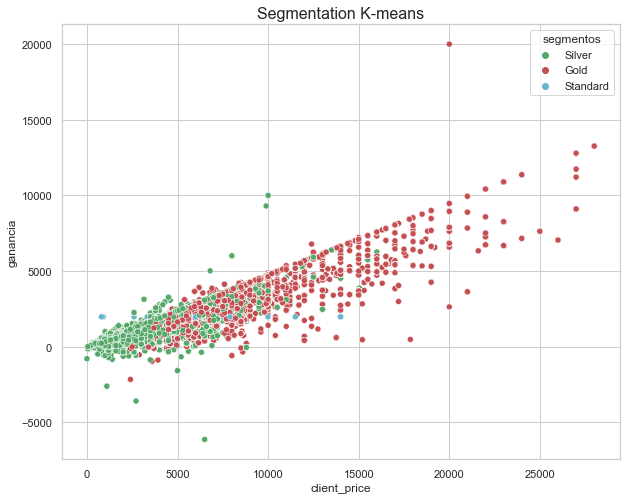

In [266]:
# Ploteamos los resultados del Algoritmo K-means
x_axis = df_model['client_price']
y_axis = df_model['ganancia']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_model['segmentos'], palette = ['g', 'r', 'c'])
plt.title('Segmentation K-means',fontsize=16)
plt.show()

### Implementamos un PCA y luego lo sumamos al análisis para mejorar el modelo K-means

## PCA

In [267]:

pca = PCA()

# Entrenamos el PCA con los datos normalizados
pca.fit(segmentation_std)

pca.explained_variance_ratio_

array([6.00338997e-02, 5.20718633e-02, 4.35506225e-02, 3.27541125e-02,
       2.76542860e-02, 2.55983935e-02, 2.42184090e-02, 2.30281818e-02,
       2.08093566e-02, 2.00941442e-02, 1.91510000e-02, 1.87822328e-02,
       1.79151443e-02, 1.77359048e-02, 1.76001152e-02, 1.71942695e-02,
       1.71318282e-02, 1.67299545e-02, 1.65859865e-02, 1.64577561e-02,
       1.63398144e-02, 1.62528624e-02, 1.61028579e-02, 1.60056652e-02,
       1.59300549e-02, 1.58327921e-02, 1.57384148e-02, 1.56987888e-02,
       1.56476462e-02, 1.56385821e-02, 1.56273179e-02, 1.56242560e-02,
       1.56059770e-02, 1.55597425e-02, 1.54975238e-02, 1.54780831e-02,
       1.54422268e-02, 1.53401974e-02, 1.53333427e-02, 1.52148371e-02,
       1.51714087e-02, 1.51125915e-02, 1.46111777e-02, 1.44588271e-02,
       1.42873878e-02, 1.40779003e-02, 1.35345845e-02, 1.29760056e-02,
       1.22572201e-02, 1.07205498e-02, 9.65482840e-03, 8.60490685e-03,
       6.75094085e-03, 5.80369512e-03, 3.72919797e-03, 3.55536005e-03,
      

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[9.85421312e-01 1.43560371e-02 1.47215967e-04 7.54348375e-05]


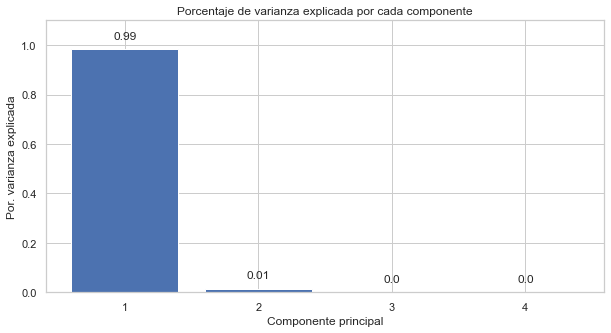

In [268]:
# Porcentaje de varianza explicada por cada componente
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)
import seaborn as sns
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [269]:
#Elegimos 3 componentes
pca = PCA(n_components = 3)
#Entrenamos el modelo PCA
pca.fit(segmentation_std)

pca.components_

array([[ 4.18391881e-01,  4.00808349e-01, -3.31340943e-02,
        -1.97825659e-01, -5.33143670e-02,  3.67688297e-01,
        -5.82138015e-02,  3.42254893e-03, -3.65858313e-02,
        -1.68779026e-02, -6.41226933e-02, -1.12504096e-02,
        -4.36131613e-02,  1.66709571e-01, -1.01276540e-01,
        -3.15611009e-02, -7.32790771e-02, -4.18855793e-02,
        -4.38043258e-03, -6.83506041e-03,  1.10637168e-01,
         8.23846493e-02, -2.65897275e-03, -8.72173461e-03,
        -2.77112560e-01, -2.88230021e-02,  3.44590708e-01,
        -1.47503091e-02,  3.08615288e-03, -3.42673596e-02,
        -1.51668828e-01, -5.42431125e-02, -4.25317995e-03,
        -1.61920673e-02, -3.73297394e-03, -6.07602442e-03,
        -2.21064818e-02, -7.29751441e-03,  3.67613941e-02,
        -3.65649081e-02,  2.96324847e-02, -7.87402227e-03,
        -7.10726515e-03, -6.23607089e-03, -5.00811865e-02,
         1.34317512e-02, -2.28545073e-02, -2.71451749e-02,
         1.71448888e-01, -7.12665109e-02, -4.26363316e-0

## Resultados PCA

In [270]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_segmentation.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,client_price,ganancia,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket
Component 1,0.42,0.40,-0.03,-0.20,-0.05,0.37,-0.06,0.00,-0.04,-0.02,-0.06,-0.01,-0.04,0.17,-0.10,-0.03,-0.07,-0.04,-0.00,-0.01,0.11,0.08,-0.00,-0.01,-0.28,-0.03,0.34,-0.01,0.00,-0.03,-0.15,-0.05,-0.00,-0.02,-0.00,-0.01,-0.02,-0.01,0.04,-0.04,0.03,-0.01,-0.01,-0.01,-0.05,0.01,-0.02,-0.03,0.17,-0.07,-0.04,-0.09,-0.05,0.00,0.11,0.15,-0.15,0.03,0.01,0.23,-0.10,-0.07,-0.05,-0.03
Component 2,-0.17,-0.16,-0.05,0.03,-0.09,0.21,-0.12,-0.06,-0.07,-0.02,0.01,0.01,0.06,-0.44,0.28,0.08,0.23,0.09,0.00,-0.00,0.16,0.07,0.00,-0.00,-0.24,0.03,-0.00,0.03,-0.01,0.08,-0.11,0.09,0.01,0.02,0.01,0.01,0.05,0.00,0.29,-0.00,0.03,0.00,0.00,0.00,-0.27,0.02,-0.03,0.09,-0.10,-0.19,0.06,0.30,0.10,0.01,0.08,0.13,0.00,0.03,0.01,0.18,-0.16,-0.07,-0.02,-0.07
Component 3,0.05,0.04,0.01,0.04,-0.01,-0.03,0.01,-0.02,0.01,-0.00,-0.02,0.00,-0.01,0.03,-0.08,0.57,-0.06,-0.02,0.02,-0.00,0.02,-0.01,-0.00,0.02,-0.03,-0.01,0.01,-0.01,0.00,0.55,-0.01,-0.02,-0.00,-0.00,-0.00,0.01,-0.02,-0.00,-0.09,-0.00,-0.00,-0.00,-0.00,0.00,0.02,-0.00,0.00,0.57,-0.00,-0.01,-0.02,-0.09,-0.01,-0.00,-0.01,-0.01,-0.03,-0.00,-0.00,-0.02,0.03,0.02,-0.00,0.02


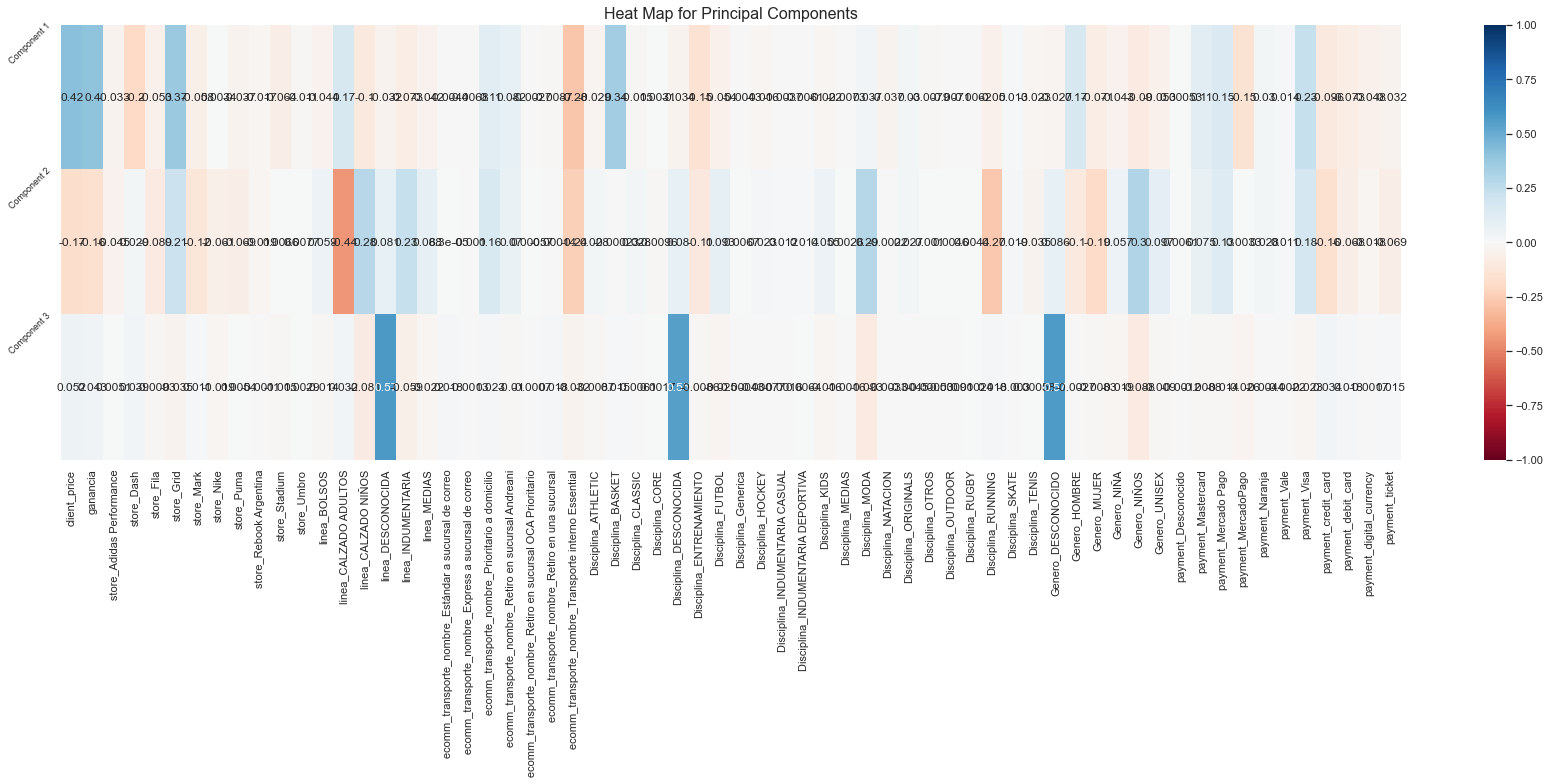

In [271]:
# Heat Map para Principal Comonent Analysis
plt.figure(figsize = (30,8))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9)
plt.title('Heat Map for Principal Components',fontsize=16)
plt.show()

In [272]:
pca.transform(segmentation_std)
score_pca = pca.transform(segmentation_std)

In [273]:
# Enrenamos K-means con la data transformada.
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(score_pca)
    wcss.append(kmeans_pca.inertia_)

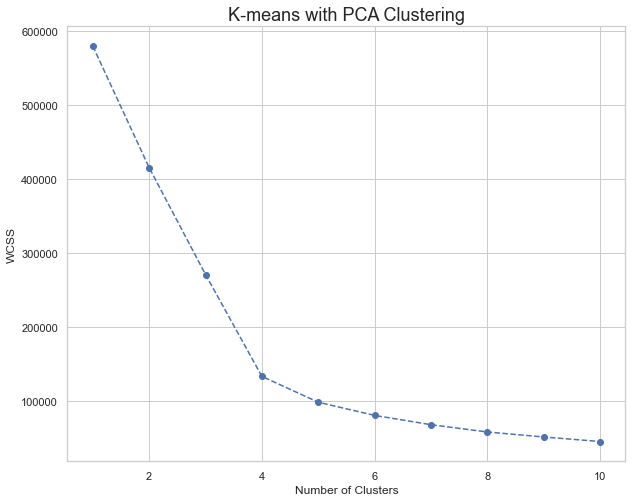

In [274]:
# PLoteamos los clusters con el medelo PCA dentro.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering',fontsize=18)
plt.show()

In [275]:
df_segm_pca_kmeans.head()

,client_price,ganancia,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket,Component 1,Component 2,Component 3,Segment K-means PCA,Legend
0,5439.20,609.86,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.27,2.34,-0.29,2,Standard
1,9499.00,3447.00,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.39,0.86,-0.21,3,Platinium
2,3839.00,523.74,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.68,2.88,-0.58,2,Standard
3,799.00,272.40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.74,3.63,-0.53,2,Standard
4,8999.00,3633.00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.88,-0.81,0.19,0,Gold


In [276]:
# We have chosen four clusters, so we run K-means with number of clusters equals four. 
# Same initializer and random state as before.
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
# We fit our data with the k-means pca model
kmeans_pca.fit(score_pca)

KMeans(n_clusters=4, random_state=42)

### ${\textbf{K-means clustering with PCA Results}}$

In [277]:
# Creamos un nuevo Data Frame y le incluimos los valores PCA
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(score_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
# La última columns muestra los resultados del k-means c/PCA
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

df_segm_pca_kmeans

,client_price,ganancia,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket,Component 1,Component 2,Component 3,Segment K-means PCA
0,5439.20,609.86,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.27,2.34,-0.29,1
1,9499.00,3447.00,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.39,0.86,-0.21,3
2,3839.00,523.74,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.68,2.88,-0.57,1
3,799.00,272.40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.74,3.63,-0.53,1
4,8999.00,3633.00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.88,-0.81,0.19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58162,5490.00,2037.87,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.34,-0.87,0.19,0
58163,2999.00,165.31,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,-1.82,3.19,-0.65,1
58164,8999.00,4262.68,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.38,-1.64,0.13,0
58165,6319.00,2281.77,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.70,-0.95,0.17,0


In [278]:
# Calculamos el promedio por segmento
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,client_price,ganancia,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6822.97,2384.84,0.03,0.42,0.09,0.03,0.18,0.11,0.10,0.01,0.03,0.00,0.00,0.96,0.00,0.00,0.03,0.00,0.00,0.00,0.03,0.00,0.00,0.01,0.80,0.00,0.01,0.00,0.00,0.00,0.31,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.01,0.00,0.00,0.00,0.00,0.44,0.00,0.04,0.00,0.46,0.51,0.00,0.00,0.03,0.00,0.01,0.01,0.24,0.00,0.00,0.03,0.40,0.19,0.04,0.08,-0.47,-1.33,0.06
1,3754.68,1204.89,0.01,0.45,0.02,0.24,0.08,0.13,0.04,0.01,0.03,0.00,0.05,0.05,0.34,0.00,0.43,0.05,0.00,0.00,0.12,0.02,0.00,0.00,0.53,0.01,0.02,0.00,0.00,0.00,0.17,0.12,0.00,0.00,0.00,0.00,0.01,0.00,0.56,0.01,0.00,0.00,0.00,0.00,0.08,0.00,0.01,0.00,0.25,0.17,0.02,0.38,0.14,0.00,0.05,0.11,0.29,0.01,0.00,0.17,0.19,0.12,0.03,0.03,-0.96,2.14,-0.48
2,6647.28,1937.79,0.02,0.71,0.00,0.03,0.12,0.01,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.02,0.00,0.24,0.00,0.00,0.02,0.20,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.20,0.00,0.00,0.00,0.43,0.23,0.03,0.09,-1.81,4.08,23.93
3,13707.25,5328.91,0.00,0.03,0.00,0.88,0.01,0.07,0.00,0.00,0.00,0.00,0.00,0.91,0.03,0.00,0.06,0.00,0.00,0.00,0.18,0.05,0.00,0.00,0.09,0.00,0.47,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.00,0.01,0.00,0.00,0.00,0.07,0.00,0.01,0.00,0.65,0.25,0.00,0.06,0.03,0.00,0.12,0.23,0.03,0.01,0.00,0.47,0.06,0.03,0.00,0.01,3.85,0.44,0.03


In [279]:
# Calculamos la cantidad y porporción de cada segmento y le asignamos una etiqueta a cada segmento.
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','ganancia']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'Gold', 
                                                          1:'Silver',
                                                          2:'Standard', 
                                                          3:'Platinium'})
df_segm_pca_kmeans_freq

,client_price,ganancia,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Gold,6822.97,2384.84,0.03,0.42,0.09,0.03,0.18,0.11,0.10,0.01,0.03,0.00,0.00,0.96,0.00,0.00,0.03,0.00,0.00,0.00,0.03,0.00,0.00,0.01,0.80,0.00,0.01,0.00,0.00,0.00,0.31,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.01,0.00,0.00,0.00,0.00,0.44,0.00,0.04,0.00,0.46,0.51,0.00,0.00,0.03,0.00,0.01,0.01,0.24,0.00,0.00,0.03,0.40,0.19,0.04,0.08,-0.47,-1.33,0.06,31874,0.55
Silver,3754.68,1204.89,0.01,0.45,0.02,0.24,0.08,0.13,0.04,0.01,0.03,0.00,0.05,0.05,0.34,0.00,0.43,0.05,0.00,0.00,0.12,0.02,0.00,0.00,0.53,0.01,0.02,0.00,0.00,0.00,0.17,0.12,0.00,0.00,0.00,0.00,0.01,0.00,0.56,0.01,0.00,0.00,0.00,0.00,0.08,0.00,0.01,0.00,0.25,0.17,0.02,0.38,0.14,0.00,0.05,0.11,0.29,0.01,0.00,0.17,0.19,0.12,0.03,0.03,-0.96,2.14,-0.48,17631,0.30
Standard,6647.28,1937.79,0.02,0.71,0.00,0.03,0.12,0.01,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.02,0.00,0.24,0.00,0.00,0.02,0.20,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.20,0.00,0.00,0.00,0.43,0.23,0.03,0.09,-1.81,4.08,23.93,261,0.00
Platinium,13707.25,5328.91,0.00,0.03,0.00,0.88,0.01,0.07,0.00,0.00,0.00,0.00,0.00,0.91,0.03,0.00,0.06,0.00,0.00,0.00,0.18,0.05,0.00,0.00,0.09,0.00,0.47,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.00,0.01,0.00,0.00,0.00,0.07,0.00,0.01,0.00,0.65,0.25,0.00,0.06,0.03,0.00,0.12,0.23,0.03,0.01,0.00,0.47,0.06,0.03,0.00,0.01,3.85,0.44,0.03,8401,0.14


In [280]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'Gold', 
                                                          1:'Silver',
                                                          2:'Standard', 
                                                          3:'Platinium'})

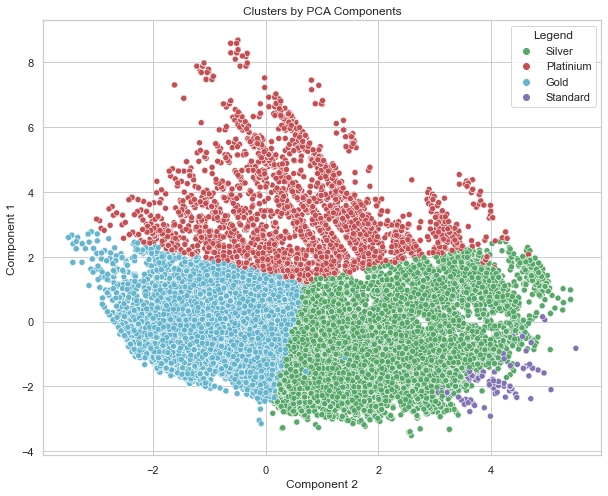

In [281]:
# Plotemoas por componentes PCA. El eje Y tiene el primer componente, y el eje X el segundo.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

In [282]:
df_segm_pca_kmeans

,client_price,ganancia,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket,Component 1,Component 2,Component 3,Segment K-means PCA,Legend
0,5439.20,609.86,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.27,2.34,-0.29,1,Silver
1,9499.00,3447.00,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.39,0.86,-0.21,3,Platinium
2,3839.00,523.74,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.68,2.88,-0.57,1,Silver
3,799.00,272.40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.74,3.63,-0.53,1,Silver
4,8999.00,3633.00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.88,-0.81,0.19,0,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58162,5490.00,2037.87,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.34,-0.87,0.19,0,Gold
58163,2999.00,165.31,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,-1.82,3.19,-0.65,1,Silver
58164,8999.00,4262.68,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.38,-1.64,0.13,0,Gold
58165,6319.00,2281.77,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.70,-0.95,0.17,0,Gold


In [283]:
# Añadimos los segmentos al df del modelo.
df_model['segmentos'] = df_segm_pca_kmeans['Legend']
df_model.head()

,client_price,ganancia,ecommerce,store,linea,ecomm_transporte_nombre,Disciplina,Genero,payment,segmentos
0,5439.20,609.86,vtex,Dash,INDUMENTARIA,Envio a domicilio Estándar,FUTBOL,HOMBRE,Mercado Pago,Silver
1,9499.00,3447.00,vtex,Grid,CALZADO ADULTOS,Envio a domicilio Estándar,MODA,MUJER,Mercado Pago,Platinium
2,3839.00,523.74,vtex,Grid,INDUMENTARIA,Envio a domicilio Estándar,MODA,MUJER,Mercado Pago,Silver
3,799.00,272.40,vtex,Grid,INDUMENTARIA,Prioritario a domicilio,MODA,MUJER,Mercado Pago,Silver
4,8999.00,3633.00,vtex,Dash,CALZADO ADULTOS,Envio a domicilio Estándar,RUNNING,MUJER,Mercado Pago,Gold


In [284]:
df_model['segmentos'].value_counts()

Gold         31873
Silver       17631
Platinium     8400
Standard       261
Name: segmentos, dtype: int64

In [285]:
variables=['store','linea','ecomm_transporte_nombre','Disciplina','Genero','payment','segmentos']

def create_dummies(df,varname):
    dummy=pd.get_dummies(df[varname], drop_first=True)
    df = df.drop(varname,axis=1)
    df=pd.concat([df,dummy], axis=1)
    return df

df_model = create_dummies(df_model,variables)

In [286]:
df_model.head()

,client_price,ganancia,ecommerce,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecomm_transporte_nombre_Estándar a sucursal de correo,ecomm_transporte_nombre_Express a sucursal de correo,ecomm_transporte_nombre_Prioritario a domicilio,ecomm_transporte_nombre_Retiro en sucursal Andreani,ecomm_transporte_nombre_Retiro en sucursal OCA Prioritario,ecomm_transporte_nombre_Retiro en una sucursal,ecomm_transporte_nombre_Transporte interno Essential,Disciplina_ATHLETIC,Disciplina_BASKET,Disciplina_CLASSIC,Disciplina_CORE,Disciplina_DESCONOCIDA,Disciplina_ENTRENAMIENTO,Disciplina_FUTBOL,Disciplina_Generica,Disciplina_HOCKEY,Disciplina_INDUMENTARIA CASUAL,Disciplina_INDUMENTARIA DEPORTIVA,Disciplina_KIDS,Disciplina_MEDIAS,Disciplina_MODA,Disciplina_NATACION,Disciplina_ORIGINALS,Disciplina_OTROS,Disciplina_OUTDOOR,Disciplina_RUGBY,Disciplina_RUNNING,Disciplina_SKATE,Disciplina_TENIS,Genero_DESCONOCIDO,Genero_HOMBRE,Genero_MUJER,Genero_NIÑA,Genero_NIÑOS,Genero_UNISEX,payment_Desconocido,payment_Mastercard,payment_Mercado Pago,payment_MercadoPago,payment_Naranja,payment_Vale,payment_Visa,payment_credit_card,payment_debit_card,payment_digital_currency,payment_ticket,segmentos_Platinium,segmentos_Silver,segmentos_Standard
0,5439.20,609.86,vtex,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,9499.00,3447.00,vtex,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,3839.00,523.74,vtex,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,799.00,272.40,vtex,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,8999.00,3633.00,vtex,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Modelo de clasificación

#### En el siguiente modelo, estableceremos que tan probable es que un comprador elija el e-commerce 'vtex' o 'Meli', dependiendo de diversas características. 

ecommerce
meli    43073
vtex    15094
dtype: int64


Número de registros 58167


La porporción de "vtex" es: 74.05 %
La porporción de "Meli" es: 25.95 %




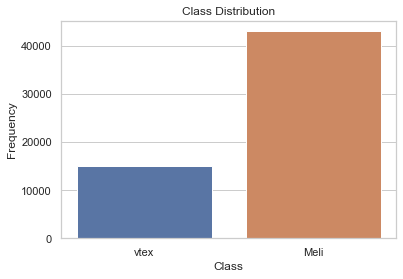

In [289]:
class_counts = df_model.groupby('ecommerce').size()
print(class_counts)
print('\n')
print('Número de registros',len(df))
print('\n')
print('La porporción de "vtex" es:',round(class_counts[0]/len(df)*100,2),'%')
print('La porporción de "Meli" es:',round(class_counts[1]/len(df)*100,2),'%')
print('\n')

LABELS = ["vtex", "Meli"]
count_classes = sns.countplot(df_model['ecommerce'])
count_classes.plot(kind = 'bar', rot=0)
plt.title("Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

### Notamos que los datos están desbalanceados, por loq ue aplicamos un algoritmo de desbalanceo para evitar problemas futuros

In [317]:
X = df_model.copy()
X = X.drop(columns={'ecommerce'})
y=np.where(df['ecommerce']=='vtex',1,0)

In [318]:
# Standarización de datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [329]:
# Partimos los datos en test y train

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=2)

In [330]:
from imblearn.combine import SMOTETomek

smoteT = SMOTETomek(random_state=38)

X_train, y_train = smoteT.fit_resample(X_train, y_train)

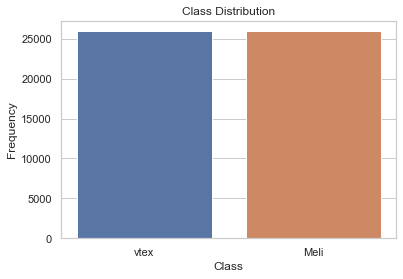

In [331]:
LABELS = ["vtex", "Meli"]
count_classes = sns.countplot(y_train)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

### Importancia de las variables

In [332]:
from sklearn.ensemble import RandomForestClassifier

algoritmo = RandomForestClassifier(n_estimators=30,max_features='sqrt',criterion='entropy')

# Entreno el modelo

clf = algoritmo.fit(X_train,y_train)

y_predict = algoritmo.predict(X_test)

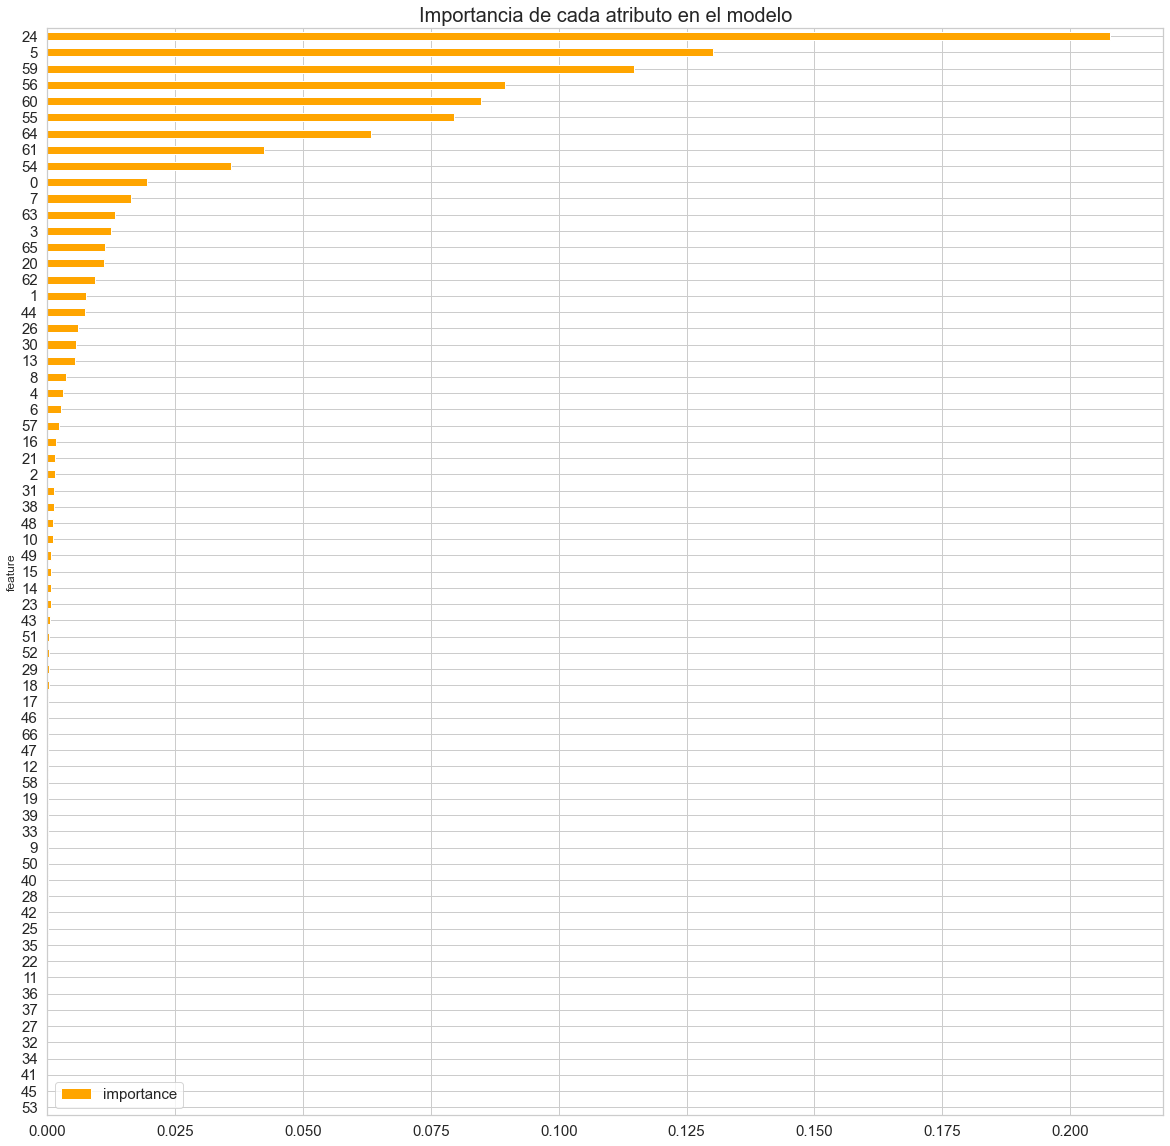

In [333]:
X_train=pd.DataFrame(X_train)
X_train.head()
features = pd.DataFrame()

features['feature'] = X_train.columns

features['importance'] = clf.feature_importances_

features.sort_values(by=['importance'], ascending=True, inplace=True)

features.set_index('feature', inplace=True)


# Para verlo de forma gráfica:
features.plot(kind='barh', figsize=(20, 20),color='orange',fontsize=15)
plt.title('Importancia de cada atributo en el modelo',fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [334]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [335]:
LR = LogisticRegression(random_state=38).fit(X_train,y_train)
DT = tree.DecisionTreeClassifier(max_depth=3,).fit(X_train,y_train)
RF = RandomForestClassifier(random_state=36).fit(X_train,y_train)
NB = GaussianNB().fit(X_train,y_train)
NN = MLPClassifier(hidden_layer_sizes=5).fit(X_train,y_train)

In [336]:
LR_Predictions = LR.predict(X_test)
DT_Predictions = DT.predict(X_test)
RF_Predictions = RF.predict(X_test)
NB_Predictions = NB.predict(X_test)
NN_Predictions = NN.predict(X_test)

In [337]:
from sklearn.model_selection import cross_val_score
print("Cross Validation Regresion logística: ",cross_val_score(LR,X_train,y_train).mean())
print("Cross Validation Arbol decisión: ",cross_val_score(DT,X_train,y_train).mean())
print("Cross Validation Random Forest: ",cross_val_score(RF,X_train,y_train).mean())
print("Cross Validation Bayes: ",cross_val_score(NB,X_train,y_train).mean())
print("Cross Validation Redes Neuronales: ",cross_val_score(NN,X_train,y_train).mean())

Cross Validation Regresion logística:  1.0
Cross Validation Arbol decisión:  0.9718141507615192
Cross Validation Random Forest:  0.9998650472334683
Cross Validation Bayes:  0.9999807210333526
Cross Validation Redes Neuronales:  0.9998843262001158


In [338]:
PredProbaLR=LR.predict_proba(X_test)

results = pd.DataFrame(data= PredProbaLR,columns=['prob_0','prob_1'])
results.head()

,prob_0,prob_1
0,1.00,0.00
1,0.00,1.00
2,1.00,0.00
3,1.00,0.00
4,1.00,0.00


In [339]:
print("Regresión logística -> ", "Accuracy: ", round(accuracy_score(y_test, LR_Predictions),2), "Precision: ", round(precision_score(y_test, LR_Predictions),2), "Recall: ", round(recall_score(y_test, LR_Predictions),2),"AUC:",round(roc_auc_score(y_test, LR_Predictions),2))
print("Arbol de decisión -> ", "Accuracy: ", round(accuracy_score(y_test, DT_Predictions),2), "Precision: ", round(precision_score(y_test, DT_Predictions),2), "Recall: ", round(recall_score(y_test, DT_Predictions),2),"AUC:",round(roc_auc_score(y_test, DT_Predictions),2))
print("Random Forest -> ", "Accuracy: ", round(accuracy_score(y_test, RF_Predictions),2), "Precision: ", round(precision_score(y_test, RF_Predictions),2), "Recall: ", round(recall_score(y_test, RF_Predictions),2),"AUC:",round(roc_auc_score(y_test, RF_Predictions),2))
print("Bayes -> ", "Accuracy: ", round(accuracy_score(y_test, NB_Predictions),2), "Precision: ", round(precision_score(y_test, NB_Predictions),2), "Recall: ", round(recall_score(y_test, NB_Predictions),2),"AUC:",round(roc_auc_score(y_test, NB_Predictions),2))
print("Redes Neuronales -> ", "Accuracy: ", round(accuracy_score(y_test, NN_Predictions),2), "Precision: ", round(precision_score(y_test, NN_Predictions),2), "Recall: ", round(recall_score(y_test, NN_Predictions),2),"AUC:",round(roc_auc_score(y_test, NN_Predictions),2))

Regresión logística ->  Accuracy:  1.0 Precision:  1.0 Recall:  1.0 AUC: 1.0
Arbol de decisión ->  Accuracy:  0.96 Precision:  0.87 Recall:  1.0 AUC: 0.97
Random Forest ->  Accuracy:  1.0 Precision:  1.0 Recall:  1.0 AUC: 1.0
Bayes ->  Accuracy:  1.0 Precision:  1.0 Recall:  1.0 AUC: 1.0
Redes Neuronales ->  Accuracy:  1.0 Precision:  1.0 Recall:  1.0 AUC: 1.0


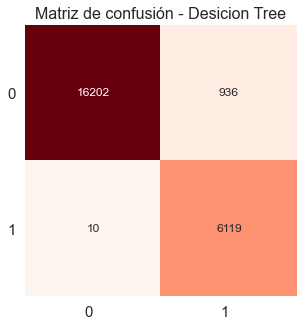

In [340]:
cm_t = confusion_matrix(y_test, DT_Predictions)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(cm_t, 
                     square=True,
                     cmap="Reds",
                     annot=True,
                     fmt="d",
                     cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
plt.title('Matriz de confusión - Desicion Tree',fontsize = 16)
plt.show()

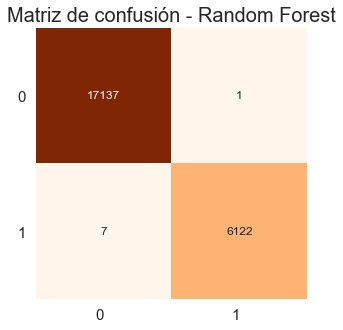

In [341]:
cm_t = confusion_matrix(y_test, RF_Predictions)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(cm_t, 
                     square=True,
                     cmap="Oranges",
                     annot=True,
                     fmt="d",
                     cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
plt.title('Matriz de confusión - Random Forest',fontsize = 20)
plt.show()

### Hiperparameter Tuning

#### Vemos que el modelo tiene una presición demasiado alta, con el tuneo de hiperparátros busamos bajar un poco esa presición.

In [353]:
# Numero de Árboles del Random Forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 30, num = 10)]
# Numero de caracterísiticas a considerar en cada split
max_features = ['auto', 'sqrt']
# Número máximo de niveles por Arbol
max_depth = [2,4]
# Número mínimo de muestras necesarias para dividir un nodo
min_samples_split = [2,4]
# Número mínimo de muestras necesarias en cada nodo hoja
min_samples_leaf = [1,5]
# Método de selección de muestras para entrenar cada árbol.
bootstrap = [True, False]

In [343]:
from sklearn.model_selection import GridSearchCV

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#Stating the Grid Search

RF_grid = GridSearchCV(RF, param_grid, cv = 5, n_jobs = -1, scoring = 'precision')

#Entrenamos con los datos de entreno...
RF_grid.fit(X_train,y_train)

#Pintamos los resultados:
print("Best parameters: ")
print(RF_grid.best_params_)

Best parameters: 
{'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}


In [344]:
#Check Accuracy
print (f'Train Accuracy - : {RF_grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {RF_grid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.993
Test Accuracy - : 0.981


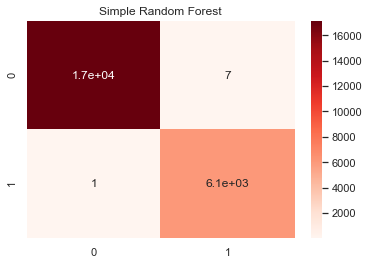

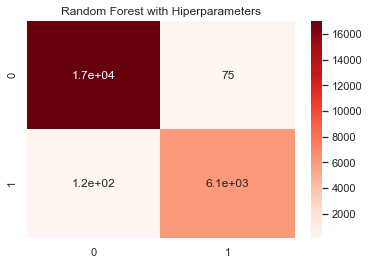

In [346]:
RF_grid_Predictions = RF_grid.predict(X_test)

#Obtención de la matriz
arrayRF = confusion_matrix(RF_Predictions, y_test)
arrayRFGrid = confusion_matrix(RF_grid_Predictions, y_test)
df_cmRF = pd.DataFrame(arrayRF)
df_cmRFGrid = pd.DataFrame(arrayRFGrid)

#Representación de la matriz de confusión
sns.set(font_scale=1)
plt.title('Simple Random Forest')
plt.show(sns.heatmap(df_cmRF, annot=True, cmap = 'Reds')) 
plt.title('Random Forest with Hiperparameters')
plt.show(sns.heatmap(df_cmRFGrid, annot=True , cmap = 'Reds'))

In [348]:
print("Random Forest Grid -> ", "Accuracy: ", round(accuracy_score(y_test, RF_grid_Predictions),2), "Precision: ", round(precision_score(y_test, RF_grid_Predictions),2), "Recall: ", round(recall_score(y_test, RF_grid_Predictions),2),"AUC:",round(roc_auc_score(y_test, RF_grid_Predictions),2))
print()
print("Random Forest -> ", "Accuracy: ", round(accuracy_score(y_test, RF_Predictions),2), "Precision: ", round(precision_score(y_test, RF_Predictions),2), "Recall: ", round(recall_score(y_test, RF_Predictions),2),"AUC:",round(roc_auc_score(y_test, RF_Predictions),2))

Random Forest Grid ->  Accuracy:  0.99 Precision:  0.98 Recall:  0.99 AUC: 0.99

Random Forest ->  Accuracy:  1.0 Precision:  1.0 Recall:  1.0 AUC: 1.0


In [347]:
from sklearn.metrics import confusion_matrix,classification_report

print('Random Forest Grid metrics')
print(classification_report(y_test, RF_grid_Predictions))

Random Forest Grid metrics
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17138
           1       0.98      0.99      0.98      6129

    accuracy                           0.99     23267
   macro avg       0.99      0.99      0.99     23267
weighted avg       0.99      0.99      0.99     23267



No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

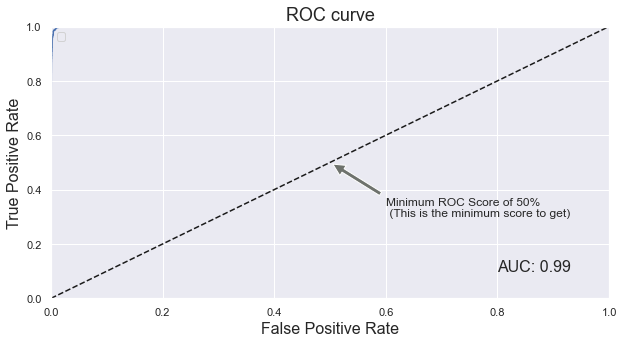

In [351]:
# Curva ROC
predictions = RF_grid.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

# Grafico de la curva ROC
plt.clf()
plt.figure(figsize=(10,5))
plt.title('ROC curve', fontsize=18)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('AUC: 0.99', xy=(0.5, 0.5), xytext=(0.8, 0.1), fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),arrowprops=dict(facecolor='#6E726D', shrink=0.05),)
plt.legend()
plt.show()

## Guardar el modelo

In [352]:
import pickle

#File Name
filename = 'Random-Forest-Grid.model'

#We save the model
pickle.dump(RF_grid, open(filename, 'wb'))